# Notebook Modelisation
## With Boosting models
### Project 7 - Part 02

# Import Libraries

In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

In [3]:
%load_ext autotime

time: 0 ns (started: 2023-03-20 14:15:21 +01:00)


In [4]:
# !{sys.executable} -m pip install shap

time: 266 ms (started: 2023-03-20 14:15:21 +01:00)


In [ ]:
import os
import sys
import time
import json
import base64
import pickle
from pickle import load
import joblib
import gc

# ----------------------------------------------------
from contextlib import contextmanager

# ----------------------------------------------------
import numpy as np
from numpy import nan
import pandas as pd

# ----------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import scipy
from scipy import stats

# ----------------------------------------------------
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from category_encoders.target_encoder import TargetEncoder

# ----------------------------------------------------
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import *
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification

# ----------------------------------------------------
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import *
from collections import Counter

# ----------------------------------------------------
from sklearn import pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# ----------------------------------------------------
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import shap
shap.initjs()

# ----------------------------------------------------
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# ----------------------------------------------------


time: 110 ms (started: 2023-03-20 14:15:26 +01:00)


# Define functions

In [8]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    

def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())

    
# ------------------------------------------------------------
def rfe_cross_validation(model):
    rfecv = RFECV(estimator=model, 
                  step=1, 
                  cv=kfold,
                  scoring='accuracy')
    return rfecv.fit(x_train, y)


# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

5:54: E225 missing whitespace around operator
5:80: E501 line too long (91 > 79 characters)
8:1: E302 expected 2 blank lines, found 1
11:5: F841 local variable 'q3_col' is assigned to but never used
16:1: E302 expected 2 blank lines, found 1
17:5: F841 local variable 'q1_col' is assigned to but never used
24:1: E302 expected 2 blank lines, found 1
26:80: E501 line too long (128 > 79 characters)
26:81: E231 missing whitespace after ','
26:113: E231 missing whitespace after ','
27:27: E231 missing whitespace after ','
28:18: E231 missing whitespace after ','
28:20: E231 missing whitespace after ','
30:18: E231 missing whitespace after ','
30:20: E231 missing whitespace after ','
35:1: E302 expected 2 blank lines, found 1
40:1: W293 blank line contains whitespace
42:1: E302 expected 2 blank lines, found 1
43:5: F841 local variable 'q1_col' is assigned to but never used
52:1: E302 expected 2 blank lines, found 1
55:5: F841 local variable 'q3_col' is assigned to but never used
62:1: E302 ex

time: 157 ms (started: 2023-03-20 14:15:26 +01:00)


# Partie I: Preprocessing
Préparation du jeu de données et feature engineering
Lecture des differents jeux de données

In [9]:
def info_df(name):
    """Read the csv file and return the dataframe and also print the number of rows and columns,
    the features of the dataframe.
    Parameters
    ----------
    name : string
           The csv file name
    Returns
    -------
    df : dataframe
    """
    data_path = '\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\data'
    df=pd.read_csv(os.path.join(data_path, name))
    print(("The dataset {} have {} rows and {} columns").format(name, df.shape[0], df.shape[1]))
    print("An overview of the dataset:")
    return df

2:80: E501 line too long (92 > 79 characters)
13:7: E225 missing whitespace around operator
14:80: E501 line too long (96 > 79 characters)


time: 110 ms (started: 2023-03-20 14:15:27 +01:00)


In [10]:
# os.chdir('\\Users\morgv\scripts_python\P7_OpenClassrooms\data')
os.chdir('\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\data')
path = str(os.getcwd())
list_of_files = []

for root, dirs, files in os.walk(path):
    for file in files:
        if(file.endswith(".csv")):
            list_of_files.append(os.path.join(root, file))
for name in list_of_files:
    print(name)
    
os.chdir('\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\Madelaine_Morgan_2_dossier_code_062022')

C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\application_test.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\application_train.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\bureau.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\bureau_balance.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\credit_card_balance.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\HomeCredit_columns_description.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\installments_payments.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\my_submission.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\POS_CASH_balance.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\pret_a_depenser.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\previous_application.csv
C:\Users\morgv\scripts_python\P7_OpenClassrooms\data\sample_submission.csv


12:1: W293 blank line contains whitespace
13:80: E501 line too long (101 > 79 characters)


time: 110 ms (started: 2023-03-20 14:15:27 +01:00)


#### Application_train

In [11]:
df_train = info_df('application_train.csv')
df_train.head()

The dataset application_train.csv have 307511 rows and 122 columns
An overview of the dataset:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


time: 5.42 s (started: 2023-03-12 02:11:32 +01:00)


#### Application_test

In [12]:
df_test = info_df('application_test.csv')
df_test.head()

The dataset application_test.csv have 48744 rows and 121 columns
An overview of the dataset:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


time: 1.02 s (started: 2023-03-12 02:11:37 +01:00)


#### Bureau

In [13]:
df = info_df('bureau.csv')
df.head()

The dataset bureau.csv have 1716428 rows and 17 columns
An overview of the dataset:


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


time: 3.39 s (started: 2023-03-12 02:11:38 +01:00)


#### Bureau_balance

In [14]:
df = info_df('bureau_balance.csv')
df.head()

The dataset bureau_balance.csv have 27299925 rows and 3 columns
An overview of the dataset:


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


time: 4.81 s (started: 2023-03-12 02:11:41 +01:00)


#### Previous_application

In [15]:
df = info_df('previous_application.csv')
df.head()

The dataset previous_application.csv have 1670214 rows and 37 columns
An overview of the dataset:


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


time: 6.77 s (started: 2023-03-12 02:11:46 +01:00)


#### POS_CASH_balance

In [16]:
df = info_df('POS_CASH_balance.csv')
df.head()

The dataset POS_CASH_balance.csv have 10001358 rows and 8 columns
An overview of the dataset:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


time: 5.5 s (started: 2023-03-12 02:11:53 +01:00)


#### Installments_payments

In [17]:
df = info_df('installments_payments.csv')
df.head()

The dataset installments_payments.csv have 13605401 rows and 8 columns
An overview of the dataset:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


time: 9.58 s (started: 2023-03-12 02:11:59 +01:00)


#### Credit_card_balance

In [18]:
df = info_df('credit_card_balance.csv')
df.head()

The dataset credit_card_balance.csv have 3840312 rows and 23 columns
An overview of the dataset:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


time: 7.94 s (started: 2023-03-12 02:12:08 +01:00)


### Prétraitement des différents jeu de données
Définissons des fonctions de prétraitement des différents jeu de données:

In [11]:
@contextmanager
def timer(title):
    """
    Processing time calculation
    """
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


def one_hot_encoder(df, nan_as_category=True):
    """
    One-hot encoding for categorical columns with get_dummies
    """
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


def application_train_test(num_rows=None, nan_as_category=False):
    """
    Preprocess application_train.csv and application_test.csv
    """
    # Read data and merge train & test data
    df = pd.read_csv(os.path.join(data_path,
                                  'application_train.csv'),
                     nrows=num_rows)
    test_df = pd.read_csv(os.path.join(data_path,
                                       'application_test.csv'),
                          nrows=num_rows)
    df = df.append(test_df).reset_index()

    # Encoding categorical features :
    # With Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER',
                        'FLAG_OWN_CAR',
                        'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature]) 
    # With One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Treatment of outliers :
    # for DAYS_EMPLOYED : Value 365.243 is outlier and replaced by nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # for CODE_GENDER : Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Feature engineering :
    # Created some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED']/df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL']/df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL']/df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY']/df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY']/df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


def bureau_and_balance(num_rows=None, nan_as_category=True):
    """
    Preprocess bureau.csv and bureau_balance.csv
    """
    # Reading data
    bureau = pd.read_csv(os.path.join(data_path,
                                      'bureau.csv'),
                         nrows=num_rows)
    bb = pd.read_csv(os.path.join(data_path,
                                  'bureau_balance.csv'),
                     nrows=num_rows)

    # Encoding categorical feature
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance : Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat :
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0]
                               + "_"
                               + e[1].upper()
                               for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg,
                         how='left',
                         on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'],
                axis=1, inplace=True)

    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

    # Bureau and bureau_balance aggregation categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations,
                                                   **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_'
                                   + e[0]
                                   + "_"
                                   + e[1].upper()
                                   for e in bureau_agg.columns.tolist()])

    # Bureau : Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_'
                                   + e[0]
                                   + "_"
                                   + e[1].upper()
                                   for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg,
                                 how='left',
                                 on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau : Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_'
                                   + e[0]
                                   + "_"
                                   + e[1].upper()
                                   for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg,
                                 how='left',
                                 on='SK_ID_CURR')

    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


def previous_applications(num_rows=None, nan_as_category=True):
    """
    Preprocess previous_applications.csv
    """
    # Reading data
    prev = pd.read_csv(os.path.join(data_path,
                                    'previous_application.csv'),
                       nrows=num_rows)

    # Enconding categorical feature
    prev, cat_cols = one_hot_encoder(prev,
                                     nan_as_category=True)

    # Treatment of outliers :
    # Value 365.243 is outlier and replaced by nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Feature Engineering :
    # Add feature : value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION']/prev['AMT_CREDIT']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    # Features : Perform aggregations
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations,
                                               **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_'
                                 + e[0]
                                 + "_"
                                 + e[1].upper()
                                 for e in prev_agg.columns.tolist()])
    # Previous Applications : Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_'
                                     + e[0]
                                     + "_"
                                     + e[1].upper()
                                     for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left',
                             on='SK_ID_CURR')
    # Previous Applications : Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_'
                                    + e[0]
                                    + "_"
                                    + e[1].upper()
                                    for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg,
                             how='left',
                             on='SK_ID_CURR')

    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


def pos_cash(num_rows=None, nan_as_category=True):
    """
    Preprocess POS_CASH_balance.csv
    """
    # Reading data
    pos = pd.read_csv(os.path.join(data_path,
                                   'POS_CASH_balance.csv'),
                      nrows= num_rows)

    # Encoding categorical features
    pos, cat_cols = one_hot_encoder(pos,
                                    nan_as_category=True)

    # Features : Perform aggregations
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_'
                                + e[0]
                                + "_"
                                + e[1].upper()
                                for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    del pos
    gc.collect()
    return pos_agg


def installments_payments(num_rows=None, nan_as_category=True):
    """
    Preprocess installments_payments.csv
    """
    # Reading data
    ins = pd.read_csv(os.path.join(data_path,
                                   'installments_payments.csv'),
                      nrows=num_rows)

    # Encoding categorical features
    ins, cat_cols = one_hot_encoder(ins,
                                    nan_as_category=True)

    # Feature engineering :
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x : x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x : x if x > 0 else 0)

    # Features : Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_'
                                + e[0]
                                + "_"
                                + e[1].upper()
                                for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    del ins
    gc.collect()
    return ins_agg


def credit_card_balance(num_rows=None, nan_as_category=True):
    """
    Preprocess credit_card_balance.csv
    """
    # Reading data
    cc = pd.read_csv(os.path.join(data_path,
                                  'credit_card_balance.csv'),
                     nrows=num_rows)

    # Encoding categorical features
    cc, cat_cols = one_hot_encoder(cc,
                                   nan_as_category=True)

    # Features : Perform aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min',
                                           'max',
                                           'mean',
                                           'sum',
                                           'var'])
    cc_agg.columns = pd.Index(['CC_'
                               + e[0]
                               + "_"
                               + e[1].upper()
                               for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    del cc
    gc.collect()
    return cc_agg


data_path = '\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\data'

16:80: E501 line too long (82 > 79 characters)
17:80: E501 line too long (82 > 79 characters)
40:65: W291 trailing whitespace
22: E203 whitespace before ':'
116:26: E701 multiple statements on one line (colon)
117:22: E701 multiple statements on one line (colon)
241:29: E251 unexpected spaces around keyword / parameter equals
284:80: E501 line too long (92 > 79 characters)
43: E203 whitespace before ':'
43: E203 whitespace before ':'


time: 203 ms (started: 2023-03-18 19:43:35 +01:00)


Definissons une fonction pour joindre les différents jeu de données prétraités:

In [12]:
def main(debug = False):
    '''Function that merges the different data sets after preprocessing.
    ----------
    Parameters:
               debug = False
    Returns:
            df: dataframe merged 
    '''
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    df = df.drop(['index'], axis=1)
    return df

1:15: E251 unexpected spaces around keyword / parameter equals
1:17: E251 unexpected spaces around keyword / parameter equals
7:33: W291 trailing whitespace


time: 109 ms (started: 2023-03-18 19:43:40 +01:00)


Définissons le dataframe des données prétraitées:

In [21]:
df_credit = main(debug = False)

Process bureau and bureau_balance - done in 21s
Process previous_applications - done in 30s
Process POS-CASH balance - done in 13s
Process installments payments - done in 33s
Process credit card balance - done in 15s


1:23: E251 unexpected spaces around keyword / parameter equals
1:25: E251 unexpected spaces around keyword / parameter equals


time: 1min 57s (started: 2023-03-12 02:12:17 +01:00)


Un aperçu de ce jeu de donnée:

In [22]:
df_credit.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 172 ms (started: 2023-03-12 02:14:14 +01:00)


In [23]:
print ("Le jeu de données compte {} lignes et {} variables".format(df_credit.shape[0], df_credit.shape[1]))

1:6: E211 whitespace before '('
1:80: E501 line too long (107 > 79 characters)


Le jeu de données compte 356255 lignes et 797 variables
time: 125 ms (started: 2023-03-12 02:14:14 +01:00)


## Preprocessing des données
### Split train / test data
Séparons les données test et entrainement:

In [24]:
data_train = df_credit[df_credit['SK_ID_CURR'].isin(df_train.SK_ID_CURR)]
data_test = df_credit[df_credit['SK_ID_CURR'].isin(df_test.SK_ID_CURR)]

data_test = data_test.drop('TARGET', axis=1)

time: 2.22 s (started: 2023-03-12 02:14:14 +01:00)


Vérifions la taille des deux jeux de données:

In [25]:
print('Training Data shape : ', data_train.shape)
print('Testing Data shape : ', data_test.shape)

Training Data shape :  (307511, 797)
Testing Data shape :  (48744, 796)
time: 141 ms (started: 2023-03-12 02:14:17 +01:00)


### Traitement des valeurs aberrantes

In [26]:
data_train_aberr = data_train.copy()
data_test_aberr = data_test.copy()

time: 906 ms (started: 2023-03-12 02:14:17 +01:00)


In [27]:
data_train_aberr.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,...,86905.000000,86905.000000,86905.000000,86273.00000,86905.0,86905.0,86905.0,86905.0,86273.0,86905.000000
mean,278180.518577,0.080729,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,...,0.049376,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605
std,102790.175348,0.272419,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,...,0.216653,0.031882,1.323208,0.02036,0.0,0.0,0.0,0.0,0.0,33.698512
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,10.000000
50%,278202.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,22.000000
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,75.000000
max,456255.000000,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,1.000000,1.000000,62.000000,0.50000,0.0,0.0,0.0,0.0,0.0,192.000000


time: 9 s (started: 2023-03-12 02:14:18 +01:00)


In [28]:
data_test_aberr.describe()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,...,16653.000000,16653.000000,16653.000000,16593.000000,16653.0,16653.0,16653.0,16653.0,16593.0,16653.000000
mean,277796.676350,0.670400,0.337129,0.309495,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,...,0.038311,0.002774,0.067195,0.002362,0.0,0.0,0.0,0.0,0.0,36.770972
std,103169.547296,0.470073,0.472734,0.462290,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,...,0.191953,0.026009,0.964846,0.017572,0.0,0.0,0.0,0.0,0.0,32.338256
min,100001.000000,0.000000,0.000000,0.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,188557.750000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,12.000000
50%,277549.000000,1.000000,0.000000,0.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,22.000000
75%,367555.500000,1.000000,1.000000,1.000000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,49.000000
max,456250.000000,1.000000,1.000000,1.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,...,1.000000,1.000000,41.000000,0.500000,0.0,0.0,0.0,0.0,0.0,140.000000


time: 2.33 s (started: 2023-03-12 02:14:27 +01:00)


Définissons une fonction qui tranforme les outliers en données manquantes:

In [13]:
def is_outlier(df,liste):
    '''Function that tranforms outliers into missing values.
    ----------
    Parameters:
               df: dataframe
               liste: list of features
    Returns:
            df: dataframe cleaned.
    '''
    for i in liste:
        q1 = df[i].quantile(.25)
        q3 = df[i].quantile(.75)
        iq_range = q3 - q1
        mask = df[i] > (q3 + (1.5* iq_range))
        df.loc[mask,i]= np.NaN
        mask2 = df[i] < (q1 - (1.5* iq_range))
        df.loc[mask2,i] = np.NaN
    return df

1:18: E231 missing whitespace after ','
14:34: E225 missing whitespace around operator
15:20: E231 missing whitespace after ','
15:23: E225 missing whitespace around operator
16:35: E225 missing whitespace around operator
17:21: E231 missing whitespace after ','


time: 110 ms (started: 2023-03-18 19:43:48 +01:00)


Transformons les valeurs aberrantes en manquantes:

In [30]:
to_be_removed = {'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'}
liste_feature = [item for item in data_test.columns if item not in to_be_removed ]
data_train_aberr = is_outlier(data_train_aberr,liste_feature)
data_test_aberr = is_outlier(data_test_aberr,liste_feature)

2:80: E501 line too long (82 > 79 characters)
2:81: E202 whitespace before ']'
3:47: E231 missing whitespace after ','
4:45: E231 missing whitespace after ','


time: 11.8 s (started: 2023-03-12 02:14:29 +01:00)


Réanalysons nos features:

In [31]:
data_train_aberr.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,303239.000000,293476.000000,3.009490e+05,299995.000000,2.925050e+05,...,82614.0,82614.0,82614.0,82014.0,86905.0,86905.0,86905.0,86905.0,86273.0,86903.000000
mean,278180.518577,0.080729,0.658370,0.340108,0.306327,0.377976,154263.935956,5.699786e+05,25924.594397,4.869864e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.140202
std,102790.175348,0.272419,0.474284,0.473746,0.460968,0.641509,64014.949755,3.527292e+05,12229.934543,2.905753e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.691417
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25650.000000,4.500000e+04,1615.500000,4.050000e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,112500.000000,2.700000e+05,16359.750000,2.295000e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000000
50%,278202.000000,0.000000,1.000000,0.000000,0.000000,0.000000,135000.000000,5.056650e+05,24543.000000,4.500000e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.000000
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,1.000000,202500.000000,7.908300e+05,33408.000000,6.750000e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.000000
max,456255.000000,1.000000,2.000000,1.000000,1.000000,2.000000,337500.000000,1.616278e+06,61699.500000,1.341000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.000000


time: 11.7 s (started: 2023-03-12 02:14:41 +01:00)


In [32]:
data_test_aberr.describe()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,48744.000000,48744.000000,48744.000000,48744.000000,48138.000000,47147.000000,4.639400e+04,47547.000000,4.662200e+04,47179.000000,...,16015.0,16015.0,16015.0,15956.0,16653.0,16653.0,16653.0,16653.0,16593.0,16596.000000
mean,277796.676350,0.670400,0.337129,0.309495,0.361502,166899.841710,4.596898e+05,28133.808442,4.126728e+05,0.019525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.509882
std,103169.547296,0.470073,0.472734,0.462290,0.628408,70439.932489,2.639866e+05,13596.038761,2.433993e+05,0.011178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.080754
min,100001.000000,0.000000,0.000000,0.000000,0.000000,26941.500000,4.500000e+04,2295.000000,4.500000e+04,0.000253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
25%,188557.750000,0.000000,0.000000,0.000000,0.000000,112500.000000,2.547000e+05,17811.000000,2.250000e+05,0.010006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000000
50%,277549.000000,1.000000,0.000000,0.000000,0.000000,157500.000000,4.312800e+05,25618.500000,3.600000e+05,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.000000
75%,367555.500000,1.000000,1.000000,1.000000,1.000000,202500.000000,6.120000e+05,35955.000000,5.400000e+05,0.026392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.000000
max,456250.000000,1.000000,1.000000,1.000000,2.000000,393750.000000,1.296000e+06,66415.500000,1.237500e+06,0.046220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.000000


time: 2.75 s (started: 2023-03-12 02:14:53 +01:00)


### Traitement des valeurs manquantes

In [33]:
data_train_aberr.isna().sum()

SK_ID_CURR                               0
TARGET                                   0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     220606
CC_NAME_CONTRACT_STATUS_nan_MEAN    220606
CC_NAME_CONTRACT_STATUS_nan_SUM     220606
CC_NAME_CONTRACT_STATUS_nan_VAR     221238
CC_COUNT                            220608
Length: 797, dtype: int64

time: 641 ms (started: 2023-03-12 02:14:55 +01:00)


In [34]:
data_test_aberr.isna().sum()

SK_ID_CURR                              0
CODE_GENDER                             0
FLAG_OWN_CAR                            0
FLAG_OWN_REALTY                         0
CNT_CHILDREN                          606
                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     32091
CC_NAME_CONTRACT_STATUS_nan_MEAN    32091
CC_NAME_CONTRACT_STATUS_nan_SUM     32091
CC_NAME_CONTRACT_STATUS_nan_VAR     32151
CC_COUNT                            32148
Length: 796, dtype: int64

time: 297 ms (started: 2023-03-12 02:14:56 +01:00)


Définissons une fonction qui calcule le pourcentage des valeurs nulles:

In [14]:
def null_factor(df, tx):
    '''Function that calculates the percentage of null values.
    ----------
    Parameters:
               df: dataframe
               tx: threshold
    Returns:
            high_null_rate: list of features 
            and their percentage of null values.
    '''
    null_rate = ((df.isnull().sum()
                  / df.shape[0])
                 *100).sort_values(ascending=False).reset_index()
    null_rate.columns = ['Variable', 'Taux_de_Null']
    high_null_rate = null_rate[null_rate.Taux_de_Null >= tx]
    return high_null_rate

8:45: W291 trailing whitespace
13:19: E225 missing whitespace around operator


time: 125 ms (started: 2023-03-18 19:43:56 +01:00)


Affichons les variables ayant le plus de valeurs nulles:

In [36]:
full_null_rate = null_factor(data_test_aberr, 80)
full_null_rate

,Variable,Taux_de_Null
0,REFUSED_AMT_DOWN_PAYMENT_MIN,86.753241
1,REFUSED_AMT_DOWN_PAYMENT_MEAN,86.371656
2,REFUSED_AMT_DOWN_PAYMENT_MAX,86.277285
3,REFUSED_RATE_DOWN_PAYMENT_MAX,85.430002
4,REFUSED_RATE_DOWN_PAYMENT_MEAN,85.204333
5,REFUSED_RATE_DOWN_PAYMENT_MIN,85.165354
6,REFUSED_APP_CREDIT_PERC_VAR,83.909815
7,CC_AMT_PAYMENT_CURRENT_MIN,82.299360
8,CC_CNT_DRAWINGS_POS_CURRENT_VAR,81.294108
9,CC_AMT_PAYMENT_CURRENT_VAR,80.998687


time: 266 ms (started: 2023-03-12 02:14:57 +01:00)


In [37]:
data_train_nan = data_train_aberr.copy()
data_test_nan = data_test_aberr.copy()

time: 2.39 s (started: 2023-03-12 02:14:57 +01:00)


Définissons une fonction qui impute par la médiane les valeurs manquantes:

In [15]:
def nan_to_median(df, liste):
    '''function that imputes by the median the missing values:.
    ----------
    Parameters:
               df: dataframe
               liste: liste of feature
    Returns:
             df: dataframe cleaned.
    '''
    for col in liste:
        df[col] = df[col].fillna(df[col].median())
    return df

time: 94 ms (started: 2023-03-18 19:44:01 +01:00)


Imputons les valeurs manquantes:

In [39]:
data_train_nan = nan_to_median(data_train_nan, liste_feature)
data_test_nan = nan_to_median(data_test_nan, liste_feature)

time: 4min 35s (started: 2023-03-12 02:14:59 +01:00)


Recontrollons les données manquantes:

In [40]:
sum(data_train_nan.isna().sum())

0

time: 734 ms (started: 2023-03-12 02:19:35 +01:00)


In [41]:
sum(data_test_nan.isna().sum())

0

time: 265 ms (started: 2023-03-12 02:19:36 +01:00)


## Exploration du jeu de données

### TARGET

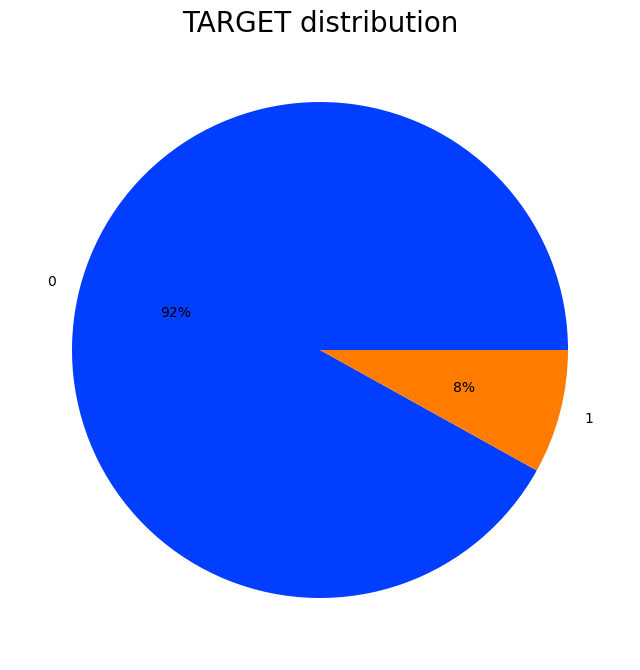

time: 437 ms (started: 2023-03-12 02:19:36 +01:00)


In [42]:
comptage_target = df_train['TARGET'].value_counts()
colors = sns.color_palette('bright')
plt.figure(figsize=(8, 10))
plt.pie(comptage_target.values,
        labels=comptage_target.index,
        colors=colors,
        autopct='%0.0f%%')
title = plt.title("TARGET distribution", fontsize=20)

Il en ressort des classes déséquilibrées:

Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.
Définissons des fonctions pour avoir une image des points métiers qui aident à orienter nos décisions dans la "prise de risque" à l'attribution d'un crédit.

In [43]:
def plot_percent_target1(data, feature, title) :
    '''function that displays the percentage of the target 1 components 
       of the feature having.
    ----------
    Parameters:
               data: dataframe
               feature: the feature
               title:  the title of the graphic
    '''  
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title,fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1",fontsize=10)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=15, fontweight='bold')

47: E203 whitespace before ':'
2:68: W291 trailing whitespace
9:8: W291 trailing whitespace
10:59: E231 missing whitespace after ','
10:80: E501 line too long (81 > 79 characters)
12:1: W293 blank line contains whitespace
13:39: E231 missing whitespace after ','
13:43: W291 trailing whitespace
15:23: E231 missing whitespace after ','
17:51: E231 missing whitespace after ','
20:17: E117 over-indented


time: 141 ms (started: 2023-03-12 02:19:36 +01:00)


#### CODE_GENDER

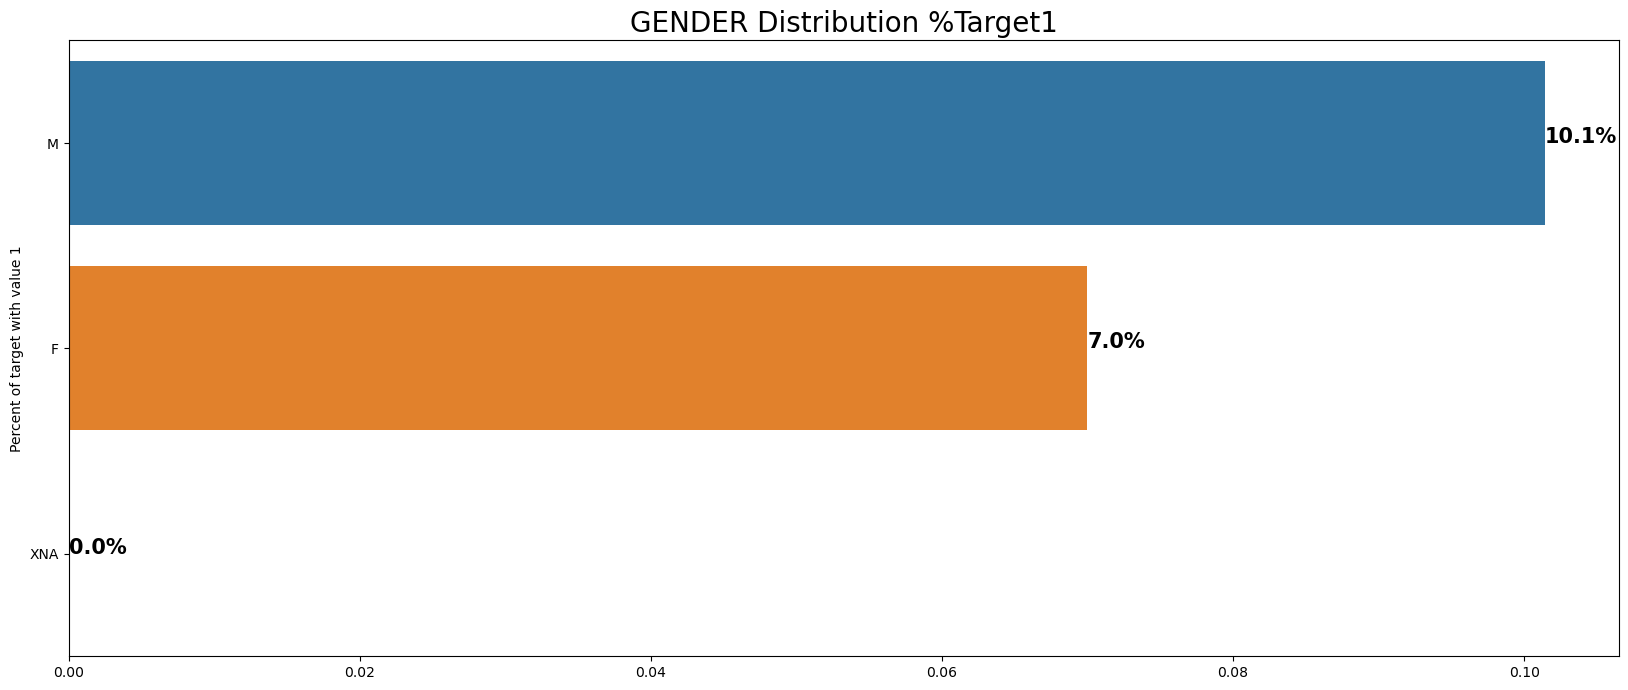

time: 360 ms (started: 2023-03-12 02:19:37 +01:00)


In [44]:
plot_percent_target1(df_train, 'CODE_GENDER', 'GENDER Distribution %Target1')

Les hommes ont plus de chances de ne pas rembourser leurs prêts (10%), comparativement aux femmes (7%).

#### NAME_FAMILY_STATUS

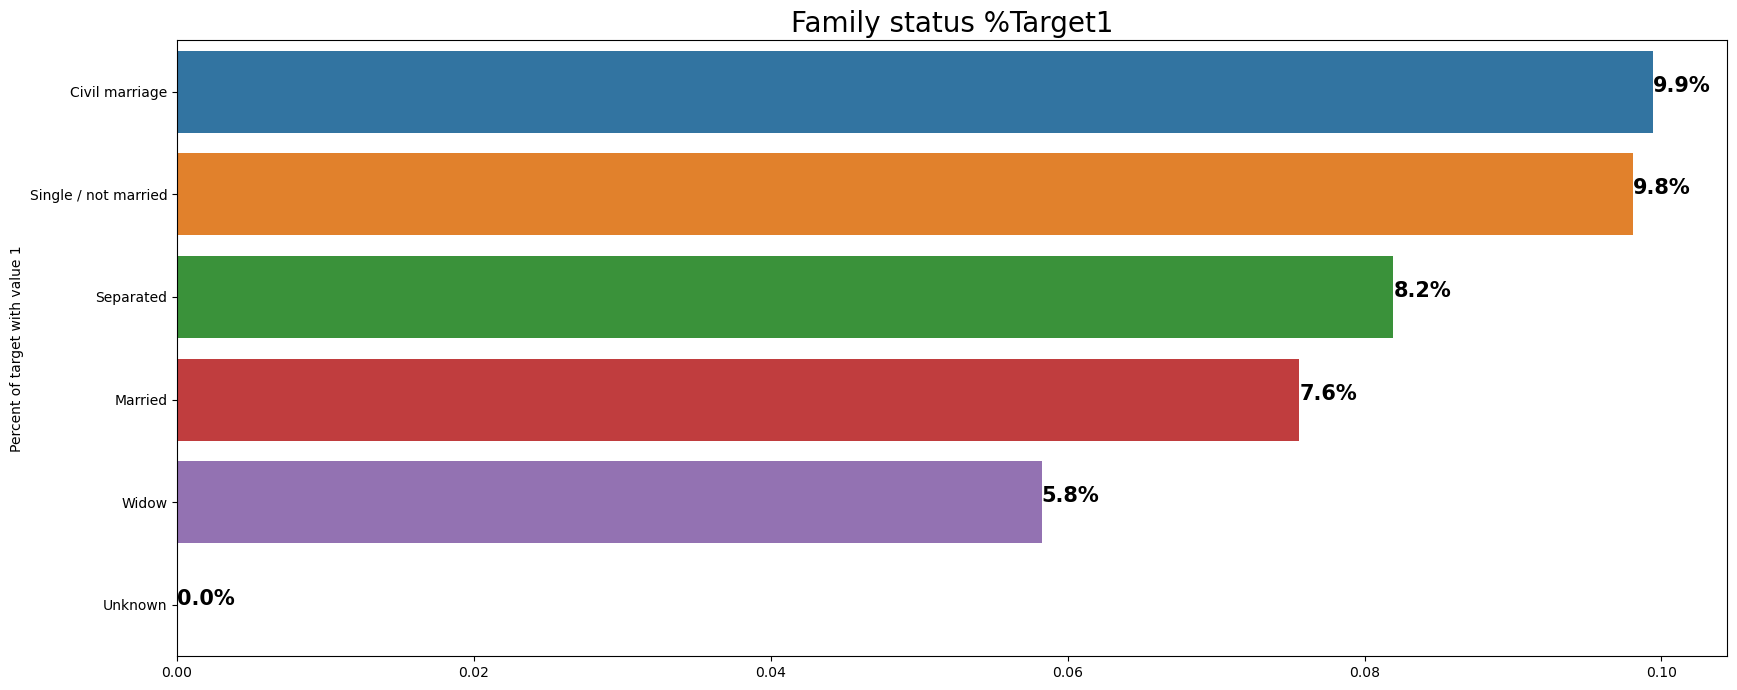

1:52: E231 missing whitespace after ','


time: 422 ms (started: 2023-03-12 02:19:37 +01:00)


In [45]:
plot_percent_target1(df_train, 'NAME_FAMILY_STATUS',"Family status %Target1")

En termes de pourcentage de non-remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10%), la veuve étant le plus bas (à l'exception de l'inconnu).

#### OCCUPATION_TYPE

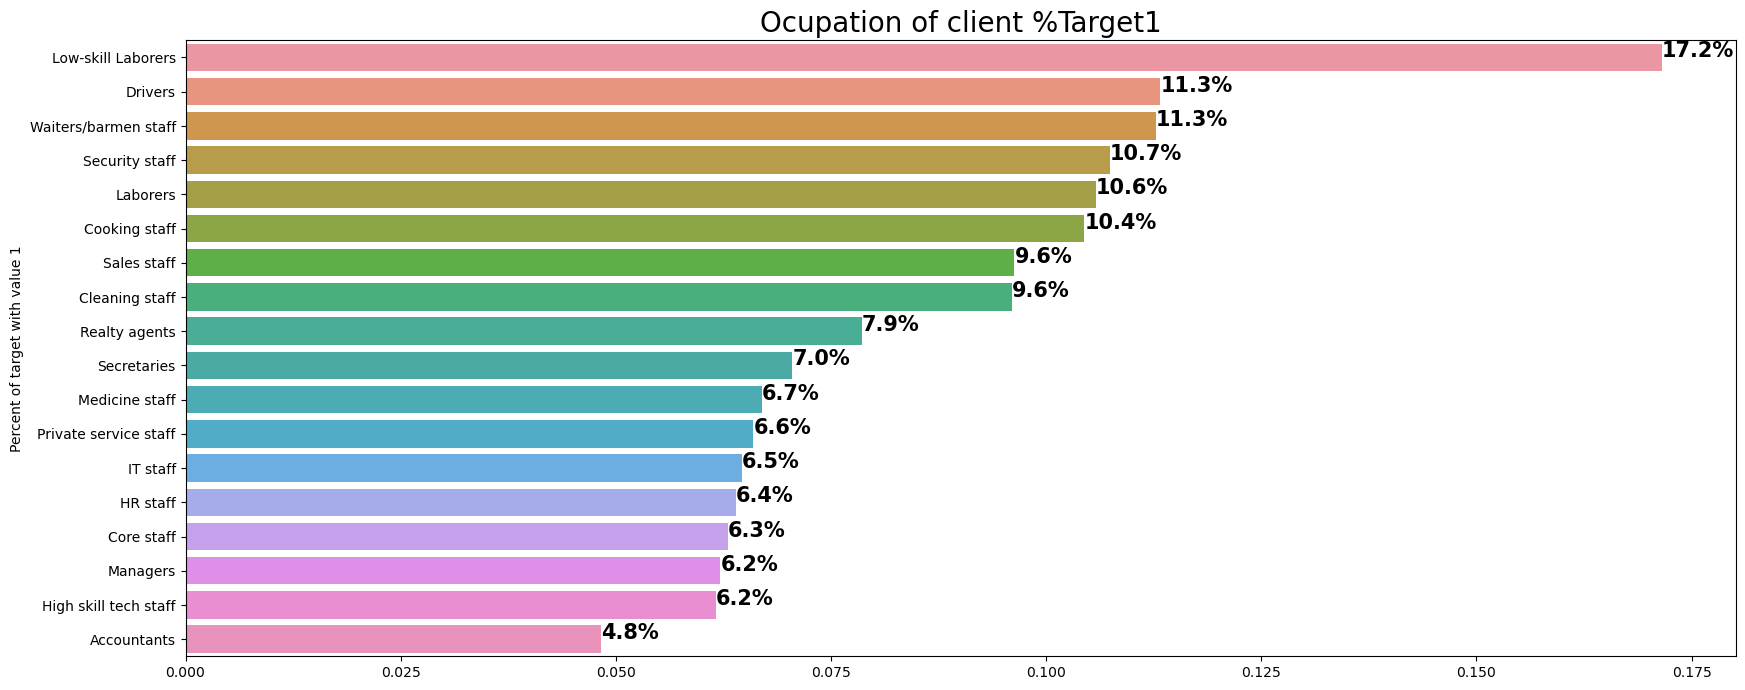

1:49: E231 missing whitespace after ','
1:80: E501 line too long (80 > 79 characters)


time: 610 ms (started: 2023-03-12 02:19:37 +01:00)


In [46]:
plot_percent_target1(df_train, 'OCCUPATION_TYPE',"Ocupation of client %Target1")

La catégorie avec le pourcentage le plus élevé de prêts non remboursés est celle des ouvriers peu qualifiés (plus de 17%), suivis des chauffeurs et des serveurs / barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

#### NAME_HOUSING_TYPE

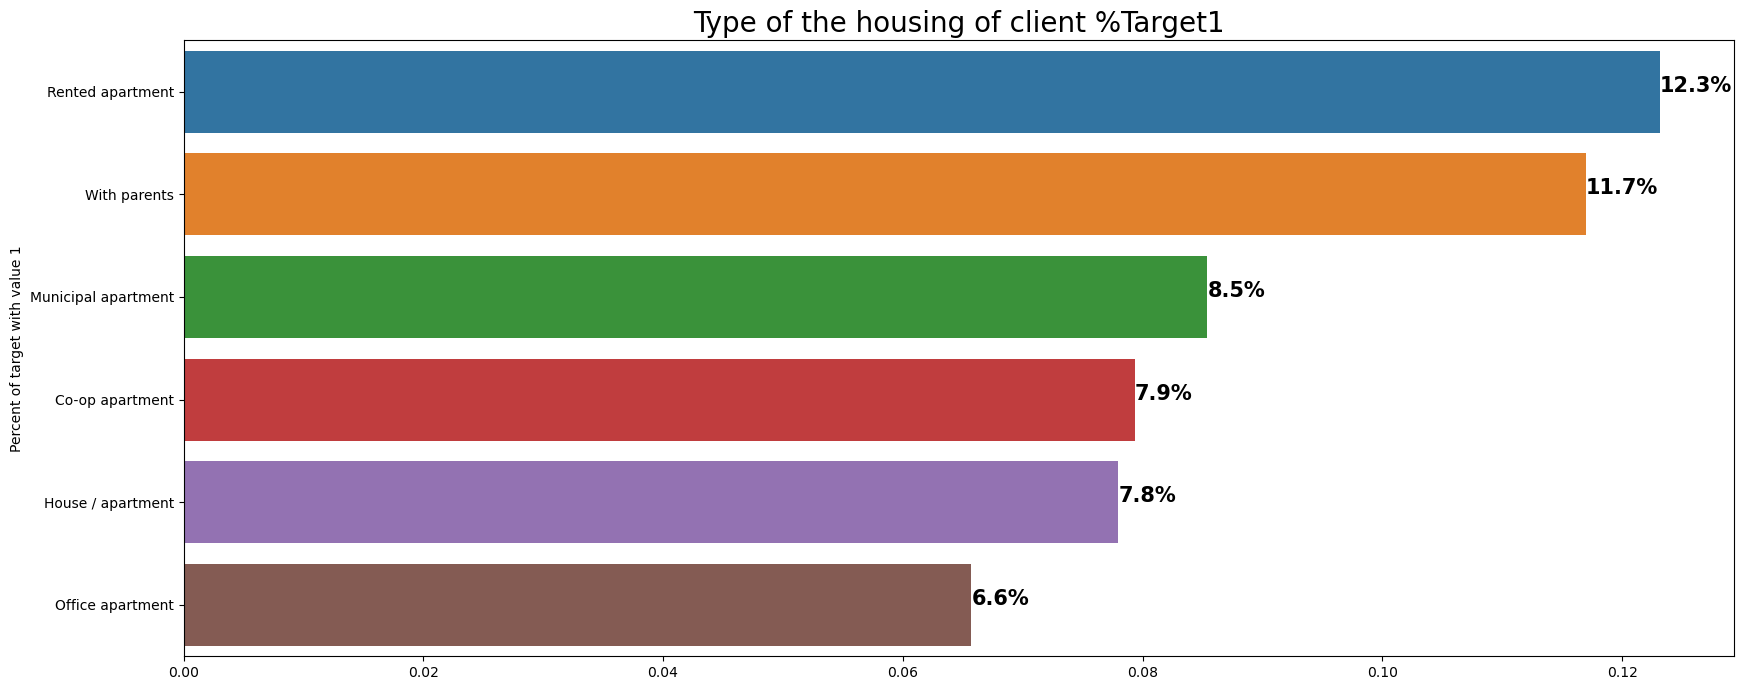

1:51: E231 missing whitespace after ','
1:80: E501 line too long (92 > 79 characters)


time: 422 ms (started: 2023-03-12 02:19:38 +01:00)


In [47]:
plot_percent_target1(df_train, 'NAME_HOUSING_TYPE',"Type of the housing of client %Target1")

Dans ces catégories, les loueurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement supérieur à 10%.

## Sauvegarde des données
Sauvegardons nos données:

In [48]:
train = data_train_nan.drop(columns=['TARGET'])
target = data_train_nan.TARGET
train.to_csv('train.csv', index=False)
target.to_csv('target.csv', index=False)
data_test_nan.to_csv('test.csv', index=False)

time: 4min 9s (started: 2023-03-12 02:19:38 +01:00)


# Partie II: Modelling
## Lecture des données
Chargeons nos données:

In [27]:
train = pd.read_csv("train.csv")
target = pd.read_csv('target.csv')
data_test_nan = pd.read_csv('test.csv')

time: 36.4 s (started: 2023-03-17 09:10:08 +01:00)


In [13]:
X = pd.read_csv("C:\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\Autres\\Addittional_files_p7\\train.csv")
y = pd.read_csv("C:\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\Autres\\Addittional_files_p7\\target.csv")

1:80: E501 line too long (111 > 79 characters)
2:80: E501 line too long (112 > 79 characters)


time: 24.1 s (started: 2023-03-20 13:58:33 +01:00)


Un aperçu des jeux de données:

In [17]:
X.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002.0,0,0,0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,100003.0,1,0,1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,100004.0,0,1,0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,100006.0,1,0,0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007.0,0,0,0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


time: 125 ms (started: 2023-03-18 19:45:20 +01:00)


In [18]:
y.head()

,TARGET
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


time: 109 ms (started: 2023-03-18 19:45:20 +01:00)


Affichons les tailles:

In [19]:
X.shape, y.shape

((307511, 796), (307511, 1))

time: 93 ms (started: 2023-03-18 19:45:20 +01:00)


### Séparation des jeux d'entrainement et de test
Séparons nos données en entrainement et test avec une proportion de 30% pour le test:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

time: 1.97 s (started: 2023-03-18 19:45:20 +01:00)


In [21]:
Id_Train = X_train.SK_ID_CURR  # new change
Id_Test = X_test.SK_ID_CURR

time: 125 ms (started: 2023-03-18 19:45:22 +01:00)


In [22]:
# drop SK_ID_Curr
X_train = X_train.drop(columns=['SK_ID_CURR'])
X_test = X_test.drop(columns=['SK_ID_CURR'])

time: 719 ms (started: 2023-03-18 19:45:22 +01:00)


In [23]:
X_test.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=795)

time: 109 ms (started: 2023-03-18 19:45:23 +01:00)


### Choix de la métrique d'évaluation des modèles
Nous utliserons l'aire sous la courbe ROC (AUC) comme métrique comparative des différents modèles.Cette derniere est egalement adaptée pour une classification avec des classes non équilibrées comme notre echantillon de travail.

### Baseline model - DummyClassifier
Afin d'avoir une première idée des performances possibles, nous utiliserons comme baseline le DummyClassifier:

Affichons les résultats pour ce classifier:

In [24]:
dc = DummyClassifier()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
dc.fit(X_train_scaled, y_train)
roc_auc = roc_auc_score(y_test, dc.predict_proba(X_test_scaled)[:, 1])
print('AUC : %0.4f' % roc_auc)
print(classification_report(y_test, dc.predict(X_test_scaled)))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

time: 2.83 s (started: 2023-03-18 19:45:23 +01:00)


Nous obtenons une précision pour le Target 0 de 0.92 et surtout la precision pour le Target 1 concernant un défaut de paiement de crédit de 0. Ceci s'explique par le déséquilibre de notre échantillon de travail qui compte 92% des individus classés en modalité 0 et 8% en modalité 1.

Il est donc intéressant de travailler sur cet suréchantillonnage en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

### Standardisation des données et oversampling
Définissons un pipeline pour executer les opérations de standardisation et réchantillonage.

Nous uliserons MinMaxScaler pour la standardisation des données et SMOTE pour oversampling:

Définissons une fonction pour executer ces opérations:

In [15]:
def define_pipeline(classifier):
    '''This function will make a standardisation and oversampling operations
    for a classifier.'''

    pipe = imbpipeline(steps=[['smote', SMOTE(random_state=11)],
                              ['scaler', MinMaxScaler()],
                              ['classifier', classifier]])
    return pipe

time: 109 ms (started: 2023-03-20 14:16:43 +01:00)


### Séléction des meilleurs modèles
Nous allons comparer les differents models de classification sur les données d'entrainement:

Listons les differents models de classification choisis:

In [16]:
classifiers = {
                  'DummyClassifier': DummyClassifier(),
                  'GaussianNB': GaussianNB(),
                  'Xgboost': XGBClassifier(),
                  'AdaBoostClassifier': AdaBoostClassifier(),
                  'Multi-layer Perceptron': MLPClassifier(),
                  'LGBM': LGBMClassifier(),
              }

time: 110 ms (started: 2023-03-20 14:16:47 +01:00)


Définissons une fonction qui calcul les scores AUC des differents models de classification au travers d'une validation croisée sur le jeu de d'entrainement:

In [17]:
def results_auc(classifiers):
    '''This function calculates the AUC scores
    of the different classification models
    through cross-validation on the training set.'''

    stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    results = {}
    for name_clf, clf in classifiers.items():
        print(name_clf)
        model = define_pipeline(clf)
        results[name_clf] = cross_val_score(model,
                                            X_train,
                                            y_train,
                                            scoring='roc_auc',
                                            cv=stratified_kfold,
                                            n_jobs=-1)
    return pd.DataFrame(results)

time: 110 ms (started: 2023-03-20 14:16:58 +01:00)


Calculons les resultats de l'AUC des différents modèles:

In [63]:
df_results = results_auc(classifiers)
df_results_mean = pd.DataFrame({"Model": [col for col in df_results.columns],
                                "AUC": [df_results[i].mean()
                                        for i in df_results.columns]})

DummyClassifier
GaussianNB
Xgboost
AdaBoostClassifier
Multi-layer Perceptron
LGBM
time: 4h 19min 31s (started: 2023-03-13 15:37:44 +01:00)


Affichons les résultats:

In [64]:
df_results_mean

,Model,AUC
0,DummyClassifier,0.500000
1,GaussianNB,0.605579
2,Xgboost,0.749817
3,AdaBoostClassifier,0.689066
4,Multi-layer Perceptron,0.655687
5,LGBM,0.760449


time: 110 ms (started: 2023-03-13 19:57:16 +01:00)


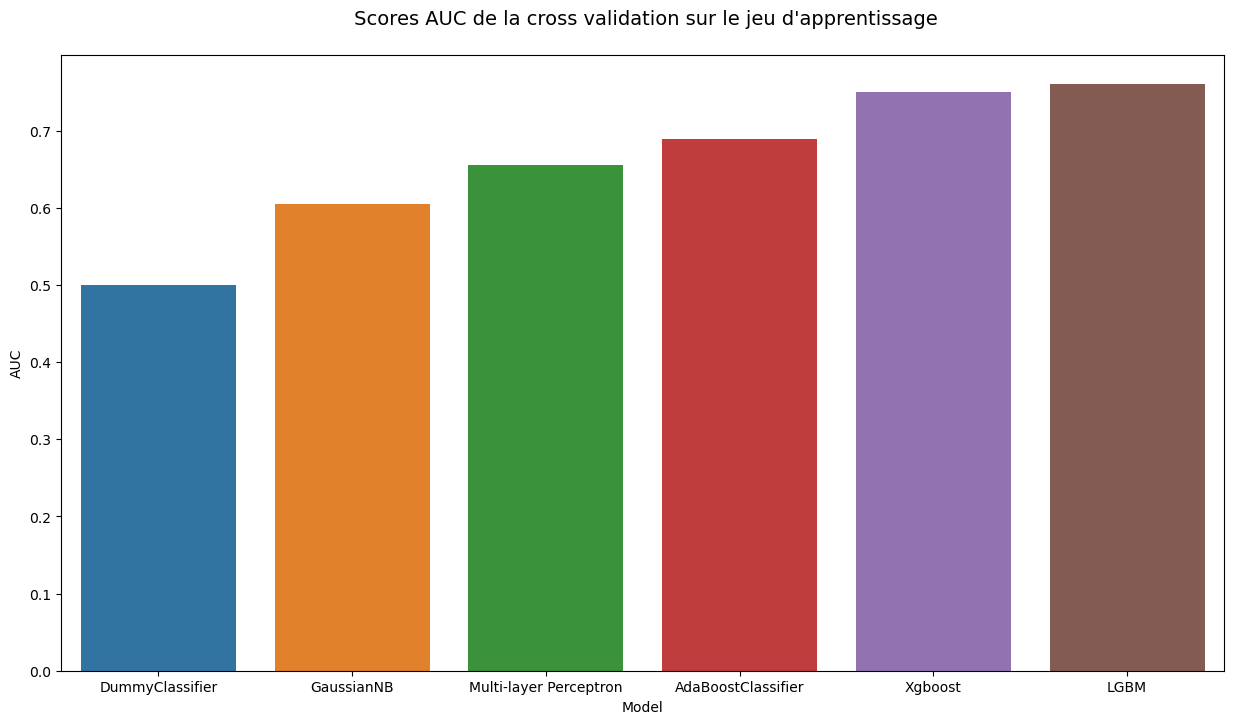

6:80: E501 line too long (87 > 79 characters)


time: 406 ms (started: 2023-03-13 23:40:07 +01:00)


In [65]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x="Model",
                 y="AUC",
                 data=df_results_mean,
                 order=df_results_mean.sort_values('AUC').Model)
title = plt.title(" Scores AUC de la cross validation sur le jeu d'apprentissage" "\n",
                  fontsize=14)

In [66]:
df_results.to_csv('C:\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\Autres\\Addittional_files_p7\\df_results.csv', index = False)
df_results_mean.to_csv('C:\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\Autres\\Addittional_files_p7\\df_results_mean.csv', index = False)

1:42: E251 unexpected spaces around keyword / parameter equals
1:44: E251 unexpected spaces around keyword / parameter equals
2:52: E251 unexpected spaces around keyword / parameter equals
2:54: E251 unexpected spaces around keyword / parameter equals


time: 125 ms (started: 2023-03-13 23:40:10 +01:00)


df_results = pd.read_csv('df_results.csv')
df_results_mean = pd.read_csv('df_results_mean.csv')

### Sélection des modèles
Les modèles linéaires suivant:

- LGBMClassifier
- XGBClassifier
- AdaBoostClassifier
offrent de meilleurs performances et des scores en moyenne à peu près similaires.

Nous essayerons d'optimiser ces modèles au travers d'une validation croisée pour le choix des meilleurs parametres.

### Feature Selection - Recursive Feature Elimination
Nos données contiennent 796 features, dont beaucoup peuvent ne pas contenir d'informations utiles. Nous allons reduire la dimension via RFECV de Scikit-learn qui appliquera une validation croisée pour trouver l'ensemble des features optimales qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes. Nous utiliserons pour cette recherche de features optimales le classifier LGBMClassifier car offrant les meilleures performances.

In [67]:
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

Fitting estimator with 795 features.
Fitting estimator with 790 features.
Fitting estimator with 785 features.
Fitting estimator with 780 features.
Fitting estimator with 775 features.
Fitting estimator with 770 features.
Fitting estimator with 765 features.
Fitting estimator with 760 features.
Fitting estimator with 755 features.
Fitting estimator with 750 features.
Fitting estimator with 745 features.
Fitting estimator with 740 features.
Fitting estimator with 735 features.
Fitting estimator with 730 features.
Fitting estimator with 725 features.
Fitting estimator with 720 features.
Fitting estimator with 715 features.
Fitting estimator with 710 features.
Fitting estimator with 705 features.
Fitting estimator with 700 features.
Fitting estimator with 695 features.
Fitting estimator with 690 features.
Fitting estimator with 685 features.
Fitting estimator with 680 features.
Fitting estimator with 675 features.
Fitting estimator with 670 features.
Fitting estimator with 665 features.
F

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(objective='binary'), n_jobs=-1,
      scoring='roc_auc', step=5, verbose=2)

2:60: W291 trailing whitespace
3:22: W291 trailing whitespace
4:37: W291 trailing whitespace
5:33: W291 trailing whitespace


time: 1h 41min 27s (started: 2023-03-13 23:40:26 +01:00)


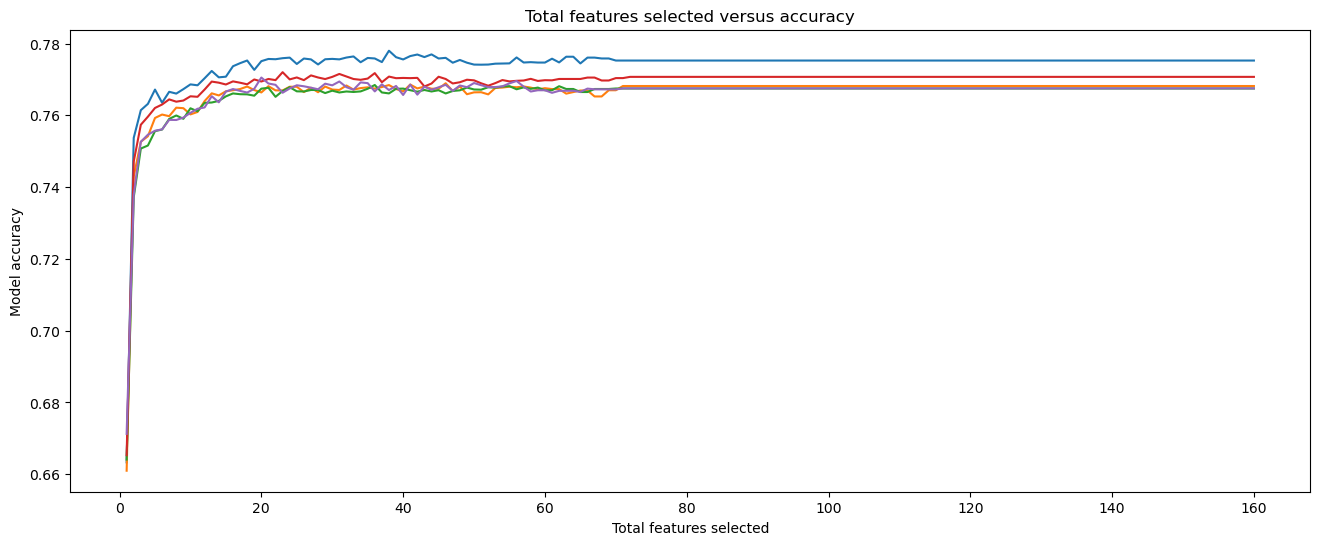

1:80: E501 line too long (95 > 79 characters)
1:96: W291 trailing whitespace


time: 360 ms (started: 2023-03-14 01:21:54 +01:00)


In [68]:
# Visualising how the model’s performance drops off when we don’t reduce the number of features 
# Plot of the number of features used in the model versus the model accuracy.

plt.figure(figsize=(16, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Affichons le nombre optimal de features:

In [69]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 200
time: 110 ms (started: 2023-03-14 01:21:54 +01:00)


Définissons notre nouveau jeu de données avec les features optimales:

In [70]:
Id_X = X.SK_ID_CURR
X_bis = X.drop(columns=['SK_ID_CURR'])

time: 3.16 s (started: 2023-03-14 01:21:55 +01:00)


In [71]:
X_rfecv = X_bis.loc[:, X_bis.columns[rfecv.get_support()]]

X_rfecv = X_rfecv.merge(y,
                        left_index=True,
                        right_index=True)  # ajout de "target"
X_rfecv.shape

(307511, 201)

time: 344 ms (started: 2023-03-14 01:21:58 +01:00)


Sauvegardons notre nouveau jeu de données:

In [ ]:
X_rfecv.to_csv('X_rfecv.csv', index=False)

In [73]:
X_rfecv.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'CC_CNT_DRAWINGS_ATM_CURRENT_MAX', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
       'CC_CNT_DRAWINGS_ATM_CURRENT_SUM', 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR',
       'CC_CNT_DRAWINGS_CURRENT_MAX', 'CC_CNT_DRAWINGS_CURRENT_MEAN',
       'CC_CNT_DRAWINGS_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_MAX',
       'CC_COUNT', 'TARGET'],
      dtype='object', length=201)

time: 141 ms (started: 2023-03-14 13:12:59 +01:00)


Lecture du jeu de données:

In [11]:
X_rfecv = pd.read_csv("C:\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\Autres\\Addittional_files_p7\\X_rfecv.csv")
X = X_rfecv.drop(columns=['TARGET'])
y = X_rfecv.TARGET

1:80: E501 line too long (119 > 79 characters)


time: 6.53 s (started: 2023-03-20 14:15:53 +01:00)


Séparons le jeu de données en test et entrainement:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

time: 579 ms (started: 2023-03-20 14:16:05 +01:00)


Définissons  une fonction qui crée un le dataframe des resultats:

In [13]:
def model_scores(pip):
    '''This function creates a dataframe
    of the gridsearch cross validation results'''
    df_results = pd.DataFrame.from_dict(pip.cv_results_
                                        ).sort_values('rank_test_score')
    return df_results

time: 94 ms (started: 2023-03-20 14:16:06 +01:00)


### hyperparamètres optimisés d’un point de vue technique via l’AUC

#### LGBMClassifier

Listons les paramètres à optimiser:

In [32]:
parameters = {'classifier__learning_rate': [0.001, 0.01, 0.2],
              'classifier__subsample': [0.6, 0.8, 0.95],
              'classifier__max_depth': [5, 10, 1],
              'classifier__n_estimators': [100, 200, 600],
              'classifier__colsample_bytree': [0.6, 1.0, 0.1]
              }

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

lgb_grid_cv = GridSearchCV(estimator=define_pipeline(LGBMClassifier()),
                           param_grid=parameters,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

time: 110 ms (started: 2023-03-18 19:48:19 +01:00)


Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres:

In [33]:
print(X_train.shape, y_train.shape)

(215257, 200) (215257,)
time: 93 ms (started: 2023-03-18 19:48:19 +01:00)


In [34]:
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_AMT_RECIVABLE_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_COUNT
127044,1,0,157500.0,706410.0,24543.0,679500.0,0.032561,-14653.0,-2062.0,-8599.0,...,528689.115,3.0,0.230769,2.0,0.423292,3.0,0.117647,0.205042,1.0,22.0
281143,1,1,121500.0,545040.0,25407.0,450000.0,0.007114,-13995.0,-2246.0,-348.0,...,2205422.190,1.0,0.428571,6.0,0.263736,4.0,0.812500,1.229167,2.0,16.0
199799,0,1,225000.0,942300.0,27679.5,675000.0,0.022625,-21687.0,-1335.0,-6306.0,...,528689.115,3.0,0.229167,22.0,0.410088,3.0,0.312500,0.511842,2.0,96.0
306749,1,0,144000.0,180000.0,9000.0,180000.0,0.006629,-13071.0,-2292.0,-742.0,...,528689.115,3.0,0.230769,2.0,0.423292,3.0,0.117647,0.205042,1.0,22.0
301347,1,0,112500.0,729792.0,37390.5,630000.0,0.046220,-19666.0,-1525.0,-169.0,...,528689.115,3.0,0.230769,2.0,0.423292,3.0,0.117647,0.205042,1.0,22.0


time: 109 ms (started: 2023-03-18 19:48:19 +01:00)


In [35]:
X_train.shape

(215257, 200)

time: 93 ms (started: 2023-03-18 19:48:19 +01:00)


In [37]:
lgb_model = lgb_grid_cv.fit(X_train, y_train)
lgb_results = model_scores(lgb_model)
lgb_best_auc = lgb_model.best_score_
lgb_best_params = lgb_model.best_params_
print("LGBMClassifier()' :\nMeilleur Score AUC : {}\nMeilleurs paramètres : {}\n"
      .format(round(lgb_best_auc, 3), lgb_best_params))

5:80: E501 line too long (81 > 79 characters)


LGBMClassifier()' :
Meilleur Score AUC : 0.758
Meilleurs paramètres : {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.6}

time: 3h 8min 55s (started: 2023-03-18 19:50:21 +01:00)


In [38]:
# changement classifier__colsample_bytree': 0.6
lgb_model = define_pipeline(classifier=LGBMClassifier(colsample_bytree=1.0,
                                                      learning_rate=0.2,
                                                      max_depth=5,
                                                      n_estimators=200,
                                                      subsample=0.6)).fit(X_train,
                                                                          y_train)

6:80: E501 line too long (82 > 79 characters)
7:80: E501 line too long (82 > 79 characters)


time: 16.7 s (started: 2023-03-18 22:59:17 +01:00)


**Save du model**

In [39]:
import pickle

# Save le model au format pickle pour le deploiement sur Heroku via Flask
model_dir = 'model'
model_file = 'lgb_model_best_params.pkl'

pickle_out = open(os.path.join(model_dir, model_file), "wb")
pickle.dump(lgb_model, pickle_out)
pickle_out.close()

time: 203 ms (started: 2023-03-18 22:59:34 +01:00)


**Lecture du model**

In [40]:
def import_predict_model(model_path):
    model = joblib.load(model_path)
    return model

time: 109 ms (started: 2023-03-18 22:59:34 +01:00)


In [ ]:
lgb_model_path = './model/lgb_model_best_params.pkl'
lgb_model = import_predict_model(lgb_model_path)

#### XGBClassifier

Listons les paramètres à optimiser:

In [18]:
parameters = {'classifier__learning_rate': [0.1, 0.01, 0.05],
              'classifier__subsample': [0, 0.25, 1.0],  # 'classifier__gamma': [0, 0.25, 1.0],
              'classifier__max_depth': [6, 15, 20],
              'classifier__n_estimators': [100, 200, 600],
              }

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=11)

xgb_grid_cv = GridSearchCV(estimator=define_pipeline(XGBClassifier()),
                           param_grid=parameters,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

2:80: E501 line too long (94 > 79 characters)


time: 109 ms (started: 2023-03-20 14:18:30 +01:00)


Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres:

In [ ]:
xgb_model = xgb_grid_cv.fit(X_train, y_train)
xgb_results = model_scores(xgb_model)
xgb_best_auc = xgb_model.best_score_
xgb_best_params = xgb_model.best_params_
print("XGBClassifier()' :\nMeilleur Score AUC : {}\nMeilleurs paramètres : {}\n"
      .format(round(xgb_best_auc, 3), xgb_best_params))

In [ ]:
# save le model au format pickle pour le deploiement sur Heroku via Flask
# save du model
model_dir = 'C:\\Users\\morgv\\scripts_python\\P7_OpenClassrooms\\Autres\\Addittional_files_p7\\model_p7_additionnal_files_from_notebook'
model_file = '\\xgb_model_best_params.pkl'

pickle_out = open(os.path.join(model_dir, model_file), "wb")
pickle.dump(xgb_model, pickle_out)
pickle_out.close()

In [25]:
xgb_model_path = './model/xgb_model_best_params.pkl'
xgb_model = import_predict_model(xgb_model_path)

time: 1.41 s (started: 2023-03-16 09:15:39 +01:00)


#### AdaBoostClassifier

Listons les paramètres à optimiser:

In [41]:
parameters = {'classifier__learning_rate': [0.1, 0.01, 0.05],
              'classifier__n_estimators': [100, 200, 600],
              'classifier__algorithm': ['SAMME.R'],
              }

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=11)

adab_grid_cv = GridSearchCV(estimator=define_pipeline(AdaBoostClassifier()),
                            param_grid=parameters,
                            scoring='roc_auc',
                            cv=stratified_kfold,
                            n_jobs=-1)

time: 109 ms (started: 2023-03-18 22:59:34 +01:00)


Affichons les résultats de la validation croisée avec le choix des meilleurs paramètres:

In [42]:
adab_model = adab_grid_cv.fit(X_train, y_train)
adb_results = model_scores(adab_model)
adab_best_auc = adab_model.best_score_
adab_best_params = adab_model.best_params_
print("AdaBosstClassifier()' :\nMeilleur Score AUC : {}\nMeilleurs paramètres : {}\n"\
      .format(round(adab_best_auc, 3), adab_best_params))

5:80: E501 line too long (86 > 79 characters)
5:86: E502 the backslash is redundant between brackets


AdaBosstClassifier()' :
Meilleur Score AUC : 0.712
Meilleurs paramètres : {'classifier__algorithm': 'SAMME.R', 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 600}

time: 2h 54min 21s (started: 2023-03-18 22:59:34 +01:00)


In [43]:
# save le model au format pickle pour le deploiement sur Heroku via Flask
# save du model
model_dir = 'model'
model_file = 'ada_model_best_params.pkl'

pickle_out = open(os.path.join(model_dir, model_file), "wb")
pickle.dump(adab_model, pickle_out)
pickle_out.close()

time: 156 ms (started: 2023-03-19 01:53:55 +01:00)


In [ ]:
ada_model_path = './model/ada_model_best_params.pkl'
adab_model = import_predict_model(ada_model_path)

### Comparaison des modèles choisis

Nous allons comparer les differents scores des modèles et les temps d'entrainement et de prédiction.

Définissons le dataframe des resultats des scores AUC et des temps d'entrainement et prédiction:

In [48]:
df_results = pd.DataFrame({"Time": [lgb_results['mean_fit_time'].mean(), lgb_results['mean_score_time'].mean()],
                       "Mean time": ['mean_fit_time', 'mean_score_time', 'mean_fit_time', 'mean_score_time',
                                'mean_fit_time', 'mean_score_time'],
                      "Score AUC": [lgb_best_auc, lgb_best_auc],
                      "Model": ['LGBMClassifier', 'LGBMClassifier']})

ValueError: All arrays must be of the same length

1:80: E501 line too long (112 > 79 characters)
2:24: E128 continuation line under-indented for visual indent
2:80: E501 line too long (108 > 79 characters)
3:33: E128 continuation line under-indented for visual indent
4:23: E128 continuation line under-indented for visual indent
5:23: E128 continuation line under-indented for visual indent


time: 187 ms (started: 2023-03-20 12:43:40 +01:00)


In [ ]:
df_results = pd.DataFrame({"Time": [adb_results['mean_fit_time'].mean(), adb_results['mean_score_time'].mean(),
                       xgb_results['mean_fit_time'].mean(), xgb_results['mean_score_time'].mean(),
                                   lgb_results['mean_fit_time'].mean(), lgb_results['mean_score_time'].mean()],
                       "Mean time": ['mean_fit_time', 'mean_score_time', 'mean_fit_time', 'mean_score_time',
                                'mean_fit_time', 'mean_score_time'],
                      "Score AUC": [adb_best_auc, adb_best_auc, xgb_best_auc, xgb_best_auc,
                                lgb_best_auc, lgb_best_auc],
                      "Model": ['AdaBosstClassifier', 'AdaBosstClassifier', 'XGBClassifier',
                         'XGBClassifier', 'LGBMClassifier', 'LGBMClassifier']})

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 8))

ax=sns.barplot(x="Model", y="Score AUC", data=df_results, ax=axes[0])
axes[0].set_title("Meilleur score AUC", color='#2cb7b0' )
ax=sns.barplot(x="Model", y="Time", hue="Mean time", data=df_results, ax=axes[1])
title=axes[1].set_title("Moyenne des temps d'entrainement et prédiction", color='#2cb7b0')
suptitle=fig.suptitle('Comparatif des scores', fontsize=18)

### Modèle retenu
compromis entre meilleur score AUC et temps d'entrainement et de prédiction, il en ressort que pour le jeu de donnée de notre étude, le modèle de classification :

- LGBMClassifier

est le modèle retenu pour les prédictions.

##  Optimisation du modèle d’un point de vue métier

#### Définition de la fonction de coût métier 

 Nous allons créer une métrique qui consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données.

Pour cela nous avons fixé un poids arbitraire pour chacune des prédictions relativement à leurs valeurs réelles.

Les valeurs des poids sont les suivantes :

- fn_value = 10  (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive.Perte réelle car le crédit client accepté se transforme en défaut de paiement.
- tp_value = 0    (True Positive)  : les cas où la prédiction et la valeur réelle sont positives.
- tn_value = 0    (True Negative)  : les cas où la prédiction et la valeur réelle sont negatives.
- fp_value = 1    (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.Perte d'opportunité car le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.
Définissons de fonction relative au calcul de cette métrique:

In [71]:
def custom_score(y_true, y_pred, fn_value=10, fp_value=1, tp_value=0, tn_value=0):
    '''function penalize false positive and false negative.'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value

    return J

1:80: E501 line too long (83 > 79 characters)
82: E203 whitespace before ':'


time: 187 ms (started: 2023-03-05 13:29:29 +01:00)


### hyperparamètres optimisés d’un point de vue métier 

Définissons les hyperparamètres à optimiser:

In [72]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
        'max_depth': hp.quniform('max_depth', 2, 30, 2),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
        'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
        'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
        'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
        'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
        'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
        'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }

2:6: E225 missing whitespace around operator
3:9: E127 continuation line over-indented for visual indent
4:80: E501 line too long (84 > 79 characters)
10:80: E501 line too long (86 > 79 characters)
11:5: E124 closing bracket does not match visual indentation


time: 203 ms (started: 2023-03-05 13:29:31 +01:00)


Définissons une fonction de minimisation de la métrique metier:

In [73]:
def optim_score(params):
    '''Optim_score function to be minimized.
    Hyperopt will seek to minimize the loss returned by this function'''
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'num_leaves': int(params['num_leaves']),
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda']
        }

    model= define_pipeline(LGBMClassifier(**params))
    cv = StratifiedKFold(5)

    y_pred = cross_val_predict(model,
                               X_train,
                               y_train,
                               method='predict',
                               cv=cv)
    score = custom_score(y_train, y_pred)

    return {'loss': score, 'params': params, 'status': STATUS_OK}

4:1: W293 blank line contains whitespace
16:10: E225 missing whitespace around operator


time: 156 ms (started: 2023-03-05 13:30:21 +01:00)


Recherchons les meilleurs paramètres qui minimisent la perte de l'entreprise:

In [74]:
best=fmin(fn=optim_score,  # function to optimize
          space=space, 
          algo=tpe.suggest,  # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=10,  # maximum number of iterations
          )

100%|██████████████████████████████████████████████████████████| 10/10 [57:21<00:00, 344.16s/trial, best loss: 20337.0]

1:5: E225 missing whitespace around operator
2:23: W291 trailing whitespace
3:80: E501 line too long (104 > 79 characters)



time: 57min 21s (started: 2023-03-05 13:30:24 +01:00)


### Model optimisé

Définissons le model relatif aux paramètres optimisés:

In [75]:
model = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],           
    colsample_bytree=best['colsample_by_tree'],
    num_leaves=int(best['num_leaves']),
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda']
                       )
lgbm = define_pipeline(model)
lgbm.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier',
                 LGBMClassifier(colsample_bytree=0.8,
                                learning_rate=0.016662953697879374,
                                max_depth=28, n_estimators=200, num_leaves=76,
                                reg_alpha=0.9, reg_lambda=0.7000000000000001,
                                subsample=0.8)]])

1:24: E261 at least two spaces before inline comment
1:25: E262 inline comment should start with '# '
5:33: W291 trailing whitespace


time: 30.3 s (started: 2023-03-05 14:27:46 +01:00)


#### Seuil de solvabilité

 Affichons le seuil de solvabilité:

In [76]:
best['solvability_threshold']

0.42500000000000004

time: 94 ms (started: 2023-03-05 14:28:16 +01:00)


Le meilleur seuil de solvabilité est de 0.425, c'est à dire que tous les individus dont les valeurs de prédictions sont inférieurs à ce seuil ne sont pas solvables.

### Matrice de confusion & AUC

Définissons une fonction pour afficher la matrice de confusion et la courbe ROC:

In [77]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of an sklearn Confusion Matrix using 
    a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(18, 13))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    fig = plt.figure(figsize=(18, 13))
    plt.subplot(222)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    fig.savefig('images\\Confusion_Matrix_AUC.png', dpi=150)
    plt.show()


2:78: W291 trailing whitespace
5:1: W293 blank line contains whitespace
10:80: E501 line too long (100 > 79 characters)
11:1: W293 blank line contains whitespace
12:80: E501 line too long (102 > 79 characters)
19:74: E225 missing whitespace around operator
19:80: E501 line too long (81 > 79 characters)


time: 218 ms (started: 2023-03-05 14:28:16 +01:00)


In [78]:
def cf_matrix_(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of an sklearn Confusion Matrix using 
    a Seaborn heatmap visualization.'''
    fig = plt.figure(figsize=(18, 13))
  
    plt.subplot(111)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    fig.savefig('images\\Confusion_Matrix.png', dpi=150)
    plt.show()

2:78: W291 trailing whitespace
5:1: W293 blank line contains whitespace
10:80: E501 line too long (100 > 79 characters)
11:1: W293 blank line contains whitespace
12:80: E501 line too long (102 > 79 characters)


time: 109 ms (started: 2023-03-05 14:28:17 +01:00)


In [79]:
def roc_auc_(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of an sklearn ROC Curve.'''

    fig = plt.figure(figsize=(18, 13))
    plt.subplot(111)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    fig.savefig('images\\AUC.png', dpi=150)
    plt.show()

7:74: E225 missing whitespace around operator
7:80: E501 line too long (81 > 79 characters)


time: 109 ms (started: 2023-03-05 14:28:17 +01:00)


#### Modéle optimisié via AUC

Affichons les résultats relatifs au metrique roc_auc:

In [80]:
roc_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])
print('AUC : %0.6f' %roc_auc)
print(classification_report(y_test, lgb_model.predict(X_test)))

AUC : 0.760419


2:22: E225 missing whitespace around operator


              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.44      0.06      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.53      0.53     92254
weighted avg       0.88      0.92      0.89     92254

time: 1.12 s (started: 2023-03-05 14:28:17 +01:00)


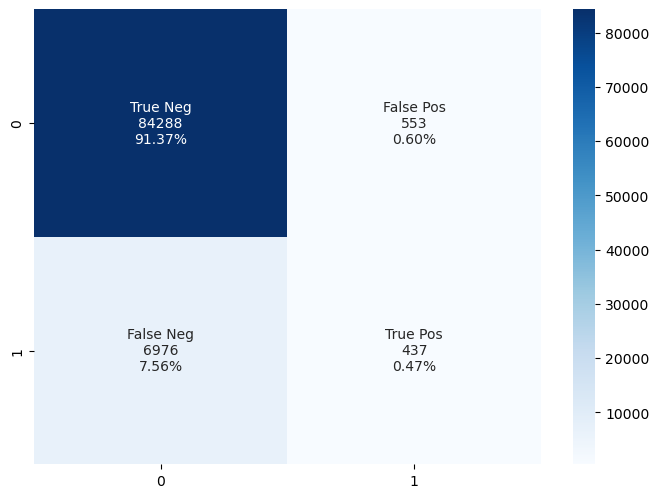

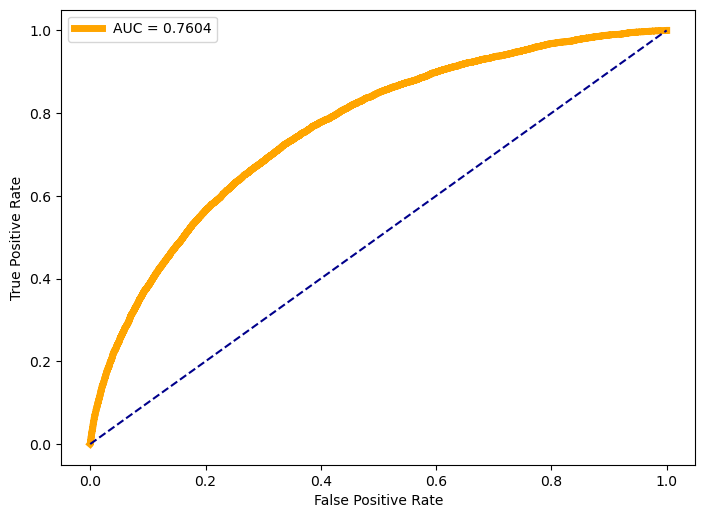

1:80: E501 line too long (102 > 79 characters)


time: 1.5 s (started: 2023-03-05 14:28:18 +01:00)


In [81]:
cf_matrix_roc_auc(lgb_model, y_test, lgb_model.predict(X_test), lgb_model.predict_proba(X_test)[:, 1])

#### Modéle optimisé via la fonction métier

Affichons les résultats relatifs à la metrique custom_score:

In [82]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])
print('AUC : %0.6f' %roc_auc)
print(classification_report(y_test, lgbm.predict(X_test)))

AUC : 0.733850


2:22: E225 missing whitespace around operator


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.32      0.02      0.03      7413

    accuracy                           0.92     92254
   macro avg       0.62      0.51      0.49     92254
weighted avg       0.87      0.92      0.88     92254

time: 1.25 s (started: 2023-03-05 14:28:20 +01:00)


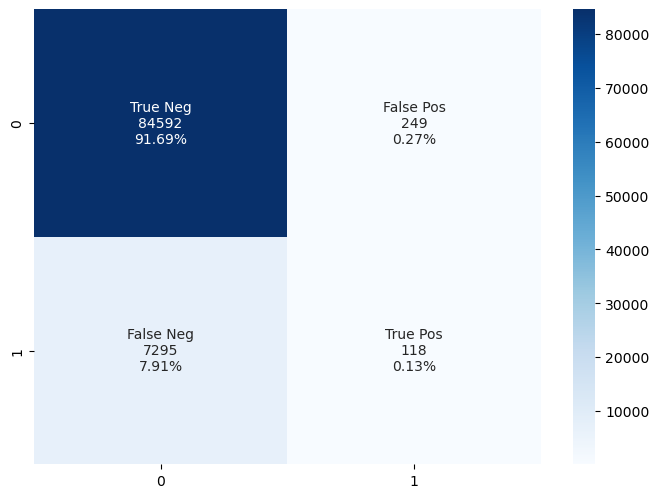

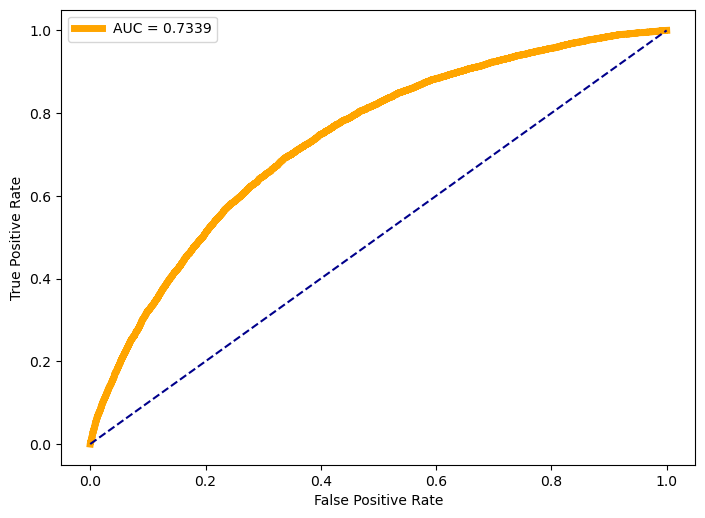

1:80: E501 line too long (87 > 79 characters)


time: 1.64 s (started: 2023-03-05 14:28:21 +01:00)


In [83]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:, 1])

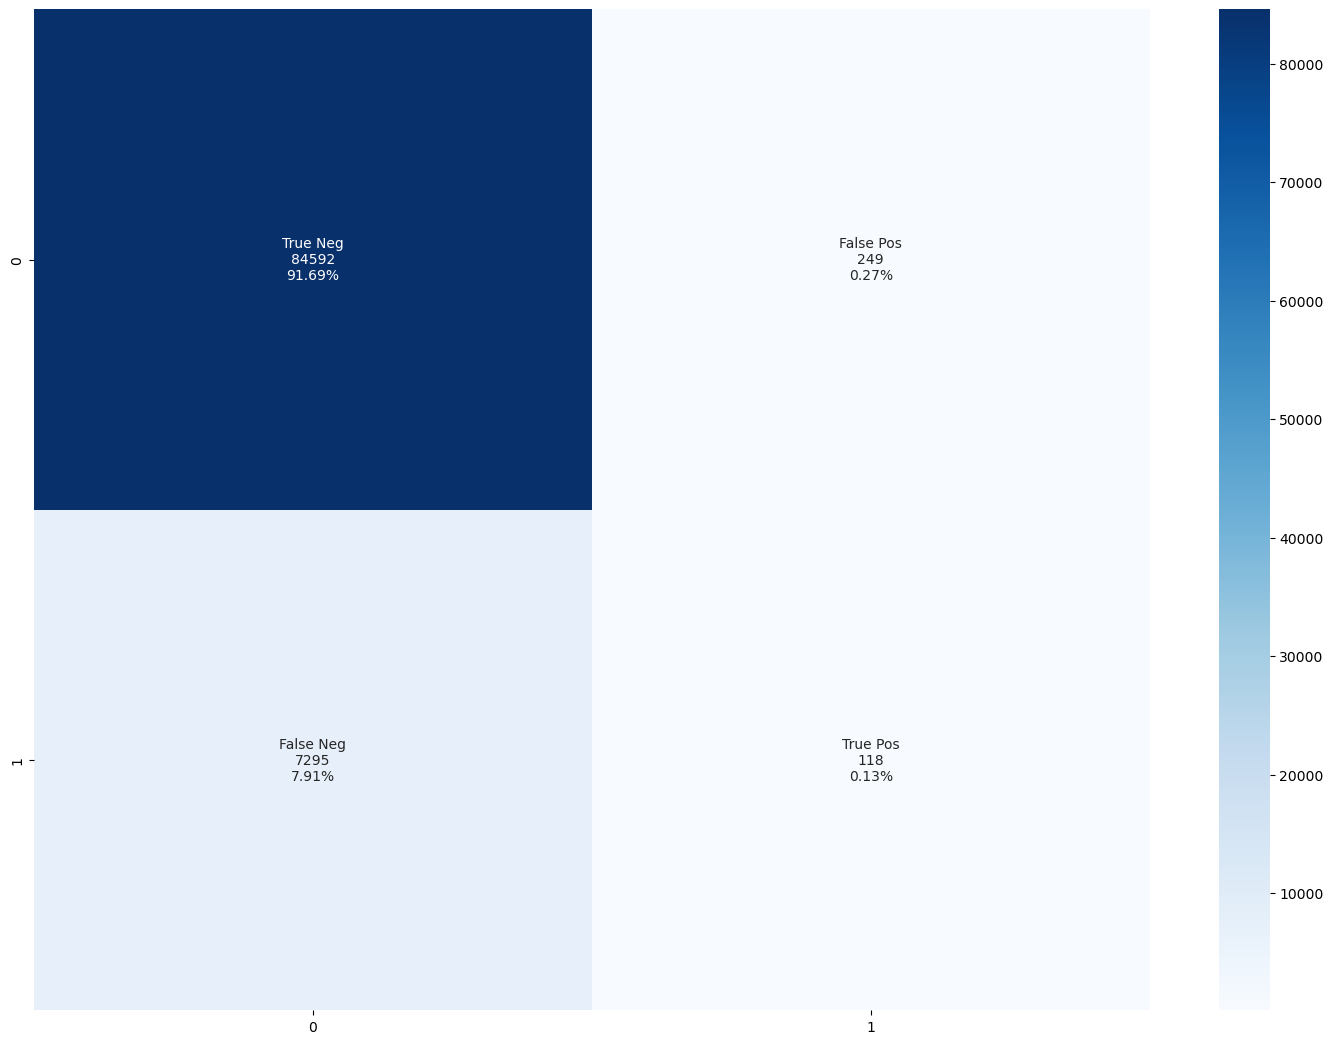

1:80: E501 line too long (80 > 79 characters)


time: 1.53 s (started: 2023-03-05 14:28:23 +01:00)


In [84]:
cf_matrix_(lgbm, y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:, 1])

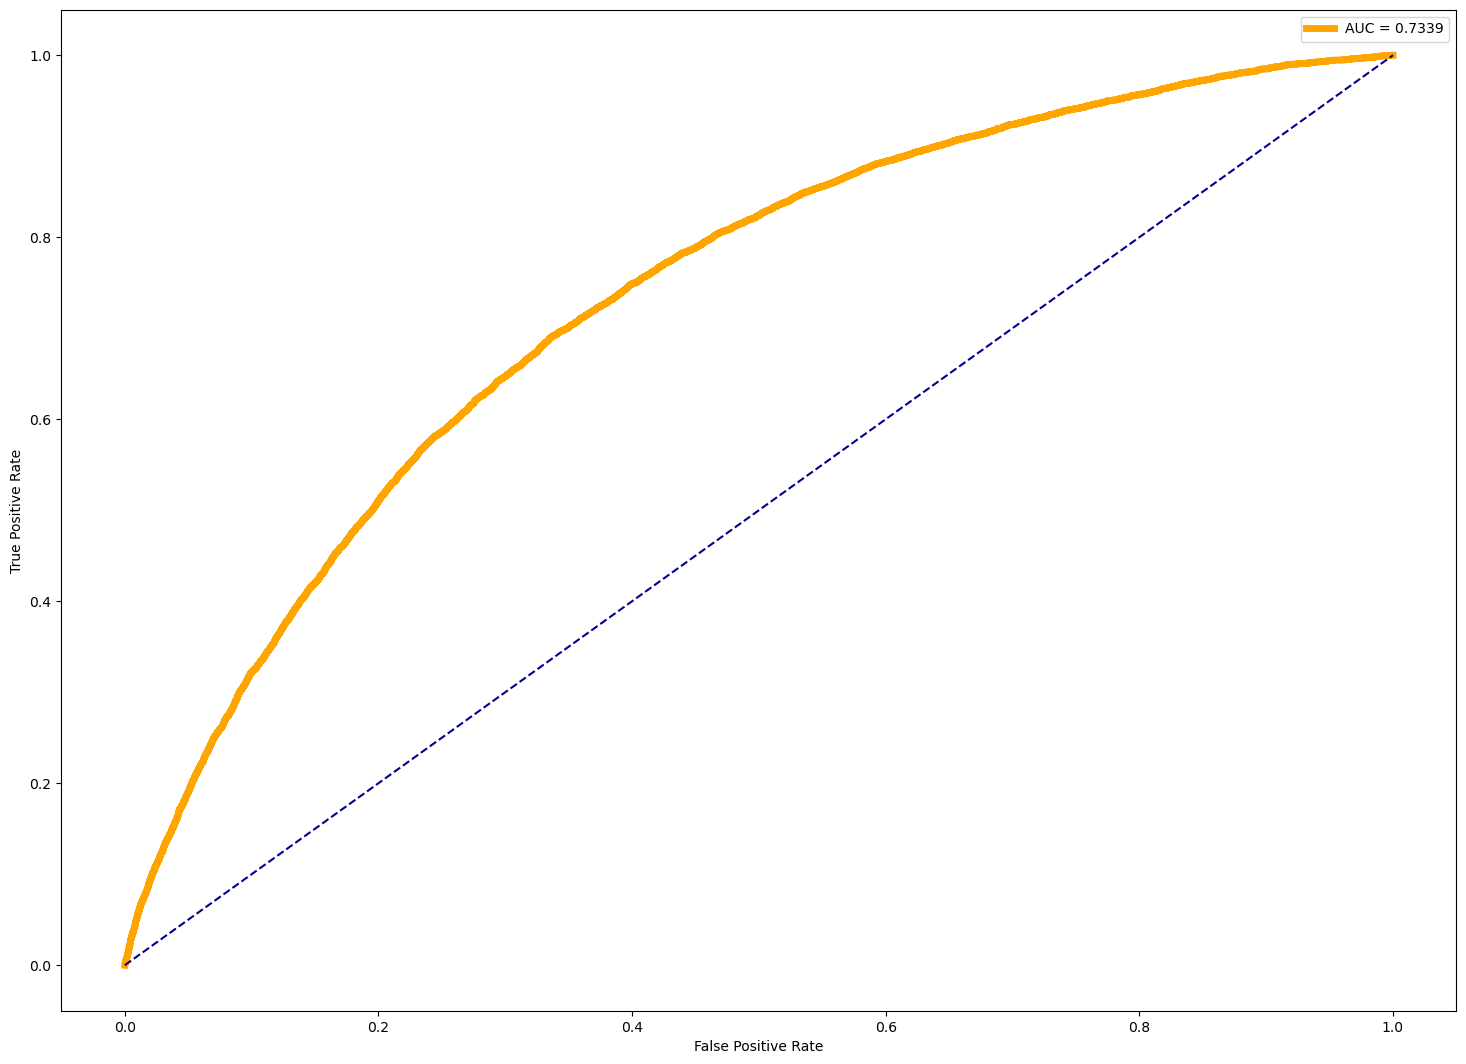

time: 1.53 s (started: 2023-03-05 14:28:24 +01:00)


In [85]:
roc_auc_(lgbm, y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:, 1])

#### Conclusion:

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier:
- les FP c'est à dire les pertes d'opportunités de l'entreprise sont estimés à 0.60% (approche AUC)contre 0.27% (approche métier).
- les FN c'est les pertes réelles de l'entreprise sont estimés à 7.56% (approche AUC) contre 7.91% (approche métier).

Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

#### Save model 

In [86]:
import pickle

# save du model au format pickle pour le deploiement sur Heroku via Flask
model_dir = 'model'
model_file = 'model_global.pkl'

pickle_out = open(os.path.join(model_dir, model_file), "wb")
pickle.dump(lgbm, pickle_out)
pickle_out.close()

time: 188 ms (started: 2023-03-05 14:28:26 +01:00)


In [87]:
# save du model
pickle_out = open("lgbm.pkl", "wb")
pickle.dump(lgbm, pickle_out)
pickle_out.close()

time: 187 ms (started: 2023-03-05 14:28:26 +01:00)


## Feature importance

### Feature importance globale

Définissons une fonction qui affiche les 20 features les plus importantes du modele:

In [88]:
def plot_feature_importances(model):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.
    
    Args:
        model: the model
        
    Returns:
        shows a plot of the 20 most importance features
    """

    indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_train.columns[indices[i]])
    
    
    # fig = plt.figure(figsize=(15, 8))
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(y=features, x=model.feature_importances_[indices[range(20)]], color=("blue"))
    plt.title("Feature Importance Globale" "\n", fontsize=22)
    plt.savefig('images\\Feature_Importance_Globale.png', dpi=150)
    plt.show()

5:1: W293 blank line contains whitespace
8:1: W293 blank line contains whitespace
14:1: W293 blank line contains whitespace
18:1: W293 blank line contains whitespace
19:1: W293 blank line contains whitespace
20:5: E303 too many blank lines (2)
22:5: F841 local variable 'ax' is assigned to but never used
22:80: E501 line too long (98 > 79 characters)


time: 110 ms (started: 2023-03-05 14:28:26 +01:00)


Affichons les features importantes du modèle:

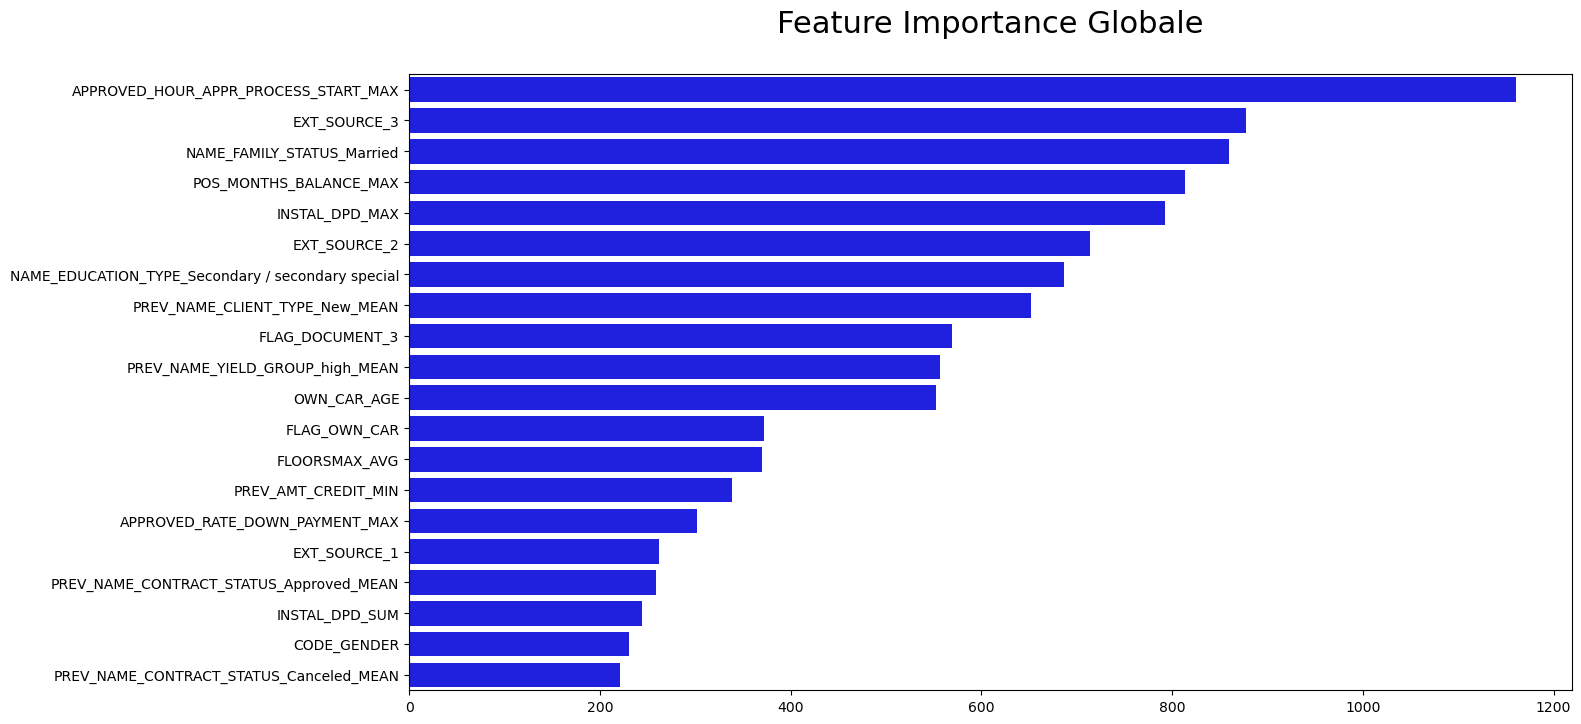

time: 578 ms (started: 2023-03-05 14:28:26 +01:00)


In [89]:
plot_feature_importances(lgbm[-1])

### Feature importance locale

#### Importance des features pour un client spécifique

Définissons notre objet lime relatif au feature importantes d'un client spécifique:

In [93]:
X_test.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'CC_AMT_RECIVABLE_SUM', 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
       'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_SUM',
       'CC_CNT_DRAWINGS_ATM_CURRENT_VAR', 'CC_CNT_DRAWINGS_CURRENT_MAX',
       'CC_CNT_DRAWINGS_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_VAR',
       'CC_CNT_DRAWINGS_POS_CURRENT_MAX', 'CC_COUNT'],
      dtype='object', length=200)

time: 94 ms (started: 2023-03-05 14:28:29 +01:00)


In [94]:
X_test_transformed = pd.DataFrame(lgbm[:2].transform(X_test),
                                  columns=X_test.columns,
                                  index=X_test.index)

lime1 = LimeTabularExplainer(X_test_transformed,
                             feature_names=X_test.columns,
                             class_names=["Solvable", "Non Solvable"],
                             discretize_continuous=False)
                            

exp = lime1.explain_instance(X_test_transformed.iloc[900],
                             lgbm.predict_proba,
                             num_samples=100)

9:1: W293 blank line contains whitespace


time: 437 ms (started: 2023-03-05 14:28:29 +01:00)


In [95]:
X_test_transformed.index[900]

264111

time: 109 ms (started: 2023-03-05 14:28:29 +01:00)


Affichage des résultats:

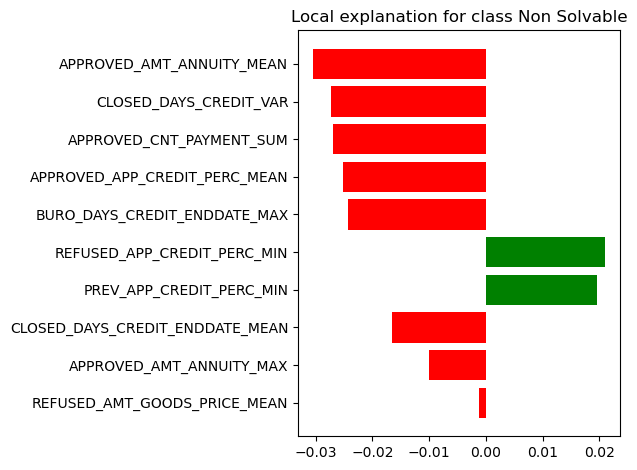

time: 344 ms (started: 2023-03-05 14:28:29 +01:00)


In [96]:
exp.show_in_notebook(show_table=False)

exp.as_pyplot_figure()
plt.tight_layout()

#### Save Explainer

In [97]:
import dill as pickle

# Local Interpretable Model-agnostic Explanations
lime1_file = 'lime_global.pkl'
model_dir = 'model'
pickle_out = open(os.path.join(model_dir, lime1_file), "wb")
pickle.dump(lime1, pickle_out)
pickle_out.close()

time: 109 ms (started: 2023-03-05 14:28:30 +01:00)


#### Save données test

In [99]:
# Réintégration de la variable 'SK_ID_CURR' sans normalisation
# X_test_transformed1 = X_test_transformed.drop(columns=['SK_ID_CURR'])
X_test_transformed1 = X_test_transformed.merge(Id_Test, left_index=True, right_index=True)  # Id_Test ou Id_X ?

3:80: E501 line too long (103 > 79 characters)


time: 140 ms (started: 2023-03-05 14:28:30 +01:00)


In [101]:
X_test_transformed1.head()

,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_COUNT,SK_ID_CURR
245895,0.0,1.0,0.581530,0.267589,0.849236,0.290657,0.203353,0.672604,0.887727,0.959372,...,0.250000,0.133136,0.0625,0.102947,0.15,0.035539,0.018069,0.05,0.168,384575.0
98194,0.5,1.0,0.711400,0.787074,0.787747,0.875433,0.142870,0.589121,0.831884,0.897315,...,0.333333,0.504808,0.4375,0.385077,0.45,0.390191,0.440457,0.40,0.184,214010.0
36463,0.5,1.0,0.567100,0.286391,0.624026,0.349481,0.772959,0.412740,0.905849,0.840105,...,0.250000,0.133136,0.0625,0.102947,0.15,0.035539,0.018069,0.05,0.168,142232.0
249923,0.5,0.0,0.711400,0.133458,0.388182,0.141869,1.000000,0.315840,0.775306,0.287773,...,0.250000,0.133136,0.0625,0.102947,0.15,0.035539,0.018069,0.05,0.168,389171.0
158389,0.0,0.0,0.278499,0.167464,0.237118,0.148789,0.404093,0.276325,0.837189,0.534473,...,0.250000,0.133136,0.0000,0.102947,0.00,0.000000,0.000000,0.05,0.192,283617.0


time: 109 ms (started: 2023-03-05 14:28:30 +01:00)


In [102]:
# SK_ID_CURR
X_test_transformed1.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'CC_CNT_DRAWINGS_ATM_CURRENT_MAX', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
       'CC_CNT_DRAWINGS_ATM_CURRENT_SUM', 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR',
       'CC_CNT_DRAWINGS_CURRENT_MAX', 'CC_CNT_DRAWINGS_CURRENT_MEAN',
       'CC_CNT_DRAWINGS_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_MAX',
       'CC_COUNT', 'SK_ID_CURR'],
      dtype='object', length=201)

time: 94 ms (started: 2023-03-05 14:28:31 +01:00)


In [103]:
X_test_transformed1.SK_ID_CURR.head()

245895    384575.0
98194     214010.0
36463     142232.0
249923    389171.0
158389    283617.0
Name: SK_ID_CURR, dtype: float64

time: 78 ms (started: 2023-03-05 14:28:31 +01:00)


In [105]:
X_test_transformed1.SK_ID_CURR = X_test_transformed1.SK_ID_CURR.astype(int)
X_test_transformed1.SK_ID_CURR.head()

245895    384575
98194     214010
36463     142232
249923    389171
158389    283617
Name: SK_ID_CURR, dtype: int32

time: 109 ms (started: 2023-03-05 14:45:54 +01:00)


In [104]:
X_test_transformed1.shape

(92254, 201)

time: 109 ms (started: 2023-03-05 14:37:19 +01:00)


In [106]:
donnees_test_file = 'donnees_test.pkl'
model_dir = 'model'
pickle_out = open(os.path.join(model_dir, donnees_test_file), "wb")
pickle.dump(X_test_transformed1, pickle_out)
pickle_out.close()

time: 344 ms (started: 2023-03-05 14:46:52 +01:00)


# Test API

In [109]:
client_Id = 100002
print(type(X_test_transformed1))
client_info = X_test_transformed1.loc[X_test_transformed1['SK_ID_CURR'] == client_Id].to_numpy()
# client_info = np.where(X_test_transformed1['SK_ID_CURR'] == client_Id)
# client_info = X_test_transformed1.loc[X_test_transformed1['SK_ID_CURR'].isin(client_Id)]
client_info

<class 'pandas.core.frame.DataFrame'>


array([[0.00000000e+00, 0.00000000e+00, 5.67099567e-01, 2.30129477e-01,
        3.84212103e-01, 2.38754325e-01, 4.03026344e-01, 8.88838782e-01,
        9.06144099e-01, 7.67332100e-01, 7.05432819e-01, 3.00000000e-01,
        7.30680423e-02, 3.07542268e-01, 1.55054452e-01, 8.68189807e-02,
        2.62599469e-01, 7.50388802e-02, 5.79315708e-02, 6.77198975e-01,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.45184134e-01, 5.15244697e-01, 9.63800905e-01, 2.95002033e-01,
        4.67960020e-01, 5.08213552e-01, 9.22846442e-01, 6.62417922e-01,
        1.15057652e-01, 3.66384522e-01, 4.80102696e-01, 4.42848937e-01,
        6.88308734e-01, 3.16577966e-01, 1.92331364e-01, 1.30275892e-01,
        1.65434225e-01, 2.03816300e-01, 3.57104996e-01, 5.10416667e-01,
        7.50000000e-01, 5.00000000e-01, 4.06960227e-01, 6.18733992e-01,
        9.06021898e-01, 6.70408751e-01, 6.28753994e-01, 4.33593750e-01,
        4.86764384e-01, 8.63877431e-01, 2.04300109e-01, 1.953165

3:80: E501 line too long (96 > 79 characters)
5:80: E501 line too long (90 > 79 characters)


time: 188 ms (started: 2023-02-05 13:51:35 +01:00)


In [110]:
X_test_transformed1.loc[X_test_transformed1['SK_ID_CURR'] == client_Id]

,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MEAN,SK_ID_CURR
0,0.0,0.0,0.5671,0.230129,0.384212,0.238754,0.403026,0.888839,0.906144,0.767332,...,0.102597,0.091633,0.191358,0.084157,0.25,0.133136,0.0625,0.102947,0.035539,100002.0


time: 125 ms (started: 2023-02-05 13:51:57 +01:00)


#### Test du scaler avec le code de l'API

In [116]:
from pickle import load

time: 109 ms (started: 2023-01-22 14:17:07 +01:00)


In [117]:
scaler_pickl = load(open(os.path.join(model_dir, scaler_file), 'rb'))  # load scaler

NameError: name 'scaler_file' is not defined

1:80: E501 line too long (84 > 79 characters)


time: 125 ms (started: 2023-01-22 14:17:07 +01:00)


In [ ]:
scaler_pickl.transform([train[top_most_important_columns].iloc[0]])

In [130]:
X_test_transformed2 = X_test_transformed1.to_numpy()
# X_test_transformed2[:, -2]
X_test_transformed2.dtype.names

time: 140 ms (started: 2023-03-05 17:24:28 +01:00)
